# Named-Entity Recognition
Implementation of a NER tagger following Chiu-Nichols' paper (2016): 
Named Entity Recognition with Bidirectional LSTM-CNNs.

Author: Pierre Nugues

## A Note on the Performance

Chiu and Nichols reported a maximal performance of 91.62 on the CoNLL 2003 English corpus. The performance we obtain here is not completely comparable to theirs as we have a slightly different configuration:
* The program below uses word and character features only. It sets aside the capitalization and lexicons features proposed by Chiu and Nichols. We believe this makes our program more easily adaptable to other languages. 
* In addition, Chiu and Nichols trained their model on the training and development sets. We only use the training set.

Nonetheless, we can try to compare their figures with ours. In Table 6 of their paper, Chiu and Nichols report a best performance of 91.62 with a model trained on the training and development sets with all the features. When trained on the training set only, they reached 91.23 (Table 8). From this, we can estimate that the contribution of the development set is of about 91.62 - 91.23 ~= 0.39. 

When using the word and character features and training their model on the training and development sets, Chiu and Nichols trained 90.91 (Table 6, second row, BLSTM-CNN). We can posit that Chiu and Nichols' system trained on the training set only would reach 90.91 - 0.39 ~= 90.52. This figure should be considered as an average over multiple runs (five to 10).

## Preliminaries

The imported modules

In [1]:
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from random import shuffle
from tensorflow.keras import callbacks
from tensorflow.keras.initializers import RandomUniform
from keras.models import Sequential, Input
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Lambda, TimeDistributed, concatenate
from tensorflow.keras.layers import LSTM, Bidirectional, SimpleRNN, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tf2crf import CRF
# from keras_contrib.layers import CRF # No longer works
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa

Using TensorFlow backend.


A few functions we'll be using

In [2]:
sys.path.append('/Users/pierre/Documents/Cours/EDAN20/programs/')

from ch06.python.conll_dictorizer import CoNLLDictorizer
from ch08.python.datasets import load_conll2003_en, load_glove_vectors
from ch08.python.rnn_preprocessing import build_sequences, to_index, to_char_index

Different possible configurations, including those from Chiu-Nichols

In [3]:
OPTIMIZER = 'rmsprop'
ANNOTATION = 'IOBES'  # 'IOBES' or 'IOB'
EMBEDDING_DIM = 100
BATCH_SIZE =  512 # Chiu-Nichols 8
EPOCHS = 80 # Chiu-Nichols 80
LSTM_UNITS = 200 # Chiu-Nichols 275
CHAR_EMBEDDING_DIM = 50  # Chiu-Nichols 25
CHAR_UNITS = 50  # Chiu-Nichols 53
CHAR_DROPOUT = 0.5 # Chiu-Nichols 0?
DROPOUT_RATE_PRE = 0.5 # Dropout before the LSTM
RECURRENT_DROPOUT = 0.5 # Chiu-Nichols 0?
DROPOUT_RATE = 0.0 # Chiu-Nichols 0.68?
DROPOUT_RATE_POST = 0.0 # Dropout after the LSTM # Chiu-Nichols 0.0?
MAX_LEN_CHARS = 20 # 10 or 20
RAND_INIT_RANGE = 0.05
ADD_CRF = True

VILDE = False  # The computing machine

config = {'Optimizer': OPTIMIZER, 'Annotation': ANNOTATION,
          'Batch size': BATCH_SIZE, 'Epochs': EPOCHS, 'LSTM units': LSTM_UNITS,
          'Char embedding dim': CHAR_EMBEDDING_DIM, 'Embedding dim': EMBEDDING_DIM,
         'Char dropout': CHAR_DROPOUT, 'Pre dropout': DROPOUT_RATE_PRE, 
          'Recurrent dropout': RECURRENT_DROPOUT, 'Dropout': DROPOUT_RATE, 
          'Post dropout': DROPOUT_RATE_POST, 'CRF': ADD_CRF}

In [4]:
np.random.seed(0)
tf.random.set_seed(0)

## Creating the $\mathbf{X}$ and $\mathbf{Y}$ matrices

In [5]:
print('Configuration::', config)
start_time = time.perf_counter()
if ANNOTATION == 'IOBES':
    if VILDE:
        train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en(
            BASE_DIR='./')
    else:
        train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en(BASE_DIR='./IOBES/')
else:
    if VILDE:
        train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en(
            BASE_DIR='/home/pierre/Cours/EDAN20/corpus/CoNLL2003/')
    else:
        train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en(
            BASE_DIR='/Users/pierre/Documents/Cours/EDAN20/programs/ch10/python/IOB/')

conll_dict = CoNLLDictorizer(column_names, col_sep=' +')
train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)
print('Second sentence, CoNLL rows:', train_dict[1])

X_train_word_cat, Y_train_cat = build_sequences(train_dict, key_x='form', key_y='ner', tolower=False)
X_dev_word_cat, Y_dev_cat = build_sequences(dev_dict, key_x='form', key_y='ner', tolower=False)
X_test_word_cat, Y_test_cat = build_sequences(test_dict, key_x='form', key_y='ner', tolower=False)
print('Second sentence, words', X_train_word_cat[1])
print('Second sentence, NER', Y_train_cat[1])

# We collect the words, named entity tags, and we create the indices
vocabulary_words_train = [word
                               for sentence in X_train_word_cat
                               for word in sentence]
vocabulary_words_dev = [word
                               for sentence in X_dev_word_cat
                               for word in sentence]
vocabulary_words_test = [word
                               for sentence in X_test_word_cat
                               for word in sentence]

Configuration:: {'Optimizer': 'rmsprop', 'Annotation': 'IOBES', 'Batch size': 512, 'Epochs': 80, 'LSTM units': 200, 'Char embedding dim': 50, 'Embedding dim': 100, 'Char dropout': 0.5, 'Pre dropout': 0.5, 'Recurrent dropout': 0.5, 'Dropout': 0.0, 'Post dropout': 0.0, 'CRF': True}
Second sentence, CoNLL rows: [{'form': 'EU', 'ppos': 'NNP', 'pchunk': 'S-NP', 'ner': 'S-ORG'}, {'form': 'rejects', 'ppos': 'VBZ', 'pchunk': 'S-VP', 'ner': 'O'}, {'form': 'German', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'S-MISC'}, {'form': 'call', 'ppos': 'NN', 'pchunk': 'E-NP', 'ner': 'O'}, {'form': 'to', 'ppos': 'TO', 'pchunk': 'B-VP', 'ner': 'O'}, {'form': 'boycott', 'ppos': 'VB', 'pchunk': 'E-VP', 'ner': 'O'}, {'form': 'British', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'S-MISC'}, {'form': 'lamb', 'ppos': 'NN', 'pchunk': 'E-NP', 'ner': 'O'}, {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}]
Second sentence, words ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
Second sentence

As vocabulary, we first extract the words in the training set

In [6]:
vocabulary_words = vocabulary_words_train
#vocabulary_words.extend(vocabulary_words_dev)
#vocabulary_words.extend(vocabulary_words_test)
vocabulary_words = list(set(vocabulary_words))
print('#words:', len(vocabulary_words))

#words: 23624


We extract all the characters

In [7]:
MAX_LEN_CHARS_OBSERVED = max([len(word) for word in vocabulary_words])
print('Word maximal length', MAX_LEN_CHARS_OBSERVED)
chars = set(' ')
for word in vocabulary_words:
    chars.update(set(word))
chars = sorted(list(chars))

NB_CHARS = len(chars)
print('#chars:', NB_CHARS)

Word maximal length 61
#chars: 85


We build the complete vocabulary: the words from the training set and those from glove

In [8]:
# We read the embeddings
if VILDE:
    embeddings_dict = load_glove_vectors(
        BASE_DIR='/home/pierre/Cours/EDAN20/corpus/')
else:
    embeddings_dict = load_glove_vectors()
embeddings_words = embeddings_dict.keys()
print('#words in GloVe:', len(embeddings_dict.keys()))
vocabulary_words = sorted(set(vocabulary_words +
                              list(embeddings_words)))
print('# unique words in the vocabulary: embeddings and corpus:',
      len(vocabulary_words))

#words in GloVe: 400000
# unique words in the vocabulary: embeddings and corpus: 411650


We set all the words in lowed case

In [9]:
vocabulary_words = set(map(str.lower, vocabulary_words))
print('# unique lowercased words in the vocabulary: embeddings and corpus:',
      len(vocabulary_words))

# unique lowercased words in the vocabulary: embeddings and corpus: 402595


We extract all the named entity tags: The classes

In [10]:
ner = sorted(set([ner
                  for sentence in Y_train_cat
                  for ner in sentence]))
NB_CLASSES = len(ner)
print(NB_CLASSES, 'named entity tags:', ner)

17 named entity tags: ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'E-LOC', 'E-MISC', 'E-ORG', 'E-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O', 'S-LOC', 'S-MISC', 'S-ORG', 'S-PER']


In [11]:
# We create the indexes
# For the words and chars, we start at two to make provision for
# the padding symbol 0 in RNN and LSTMs and unknown words/chars, 1
idx2char = dict(enumerate(chars, start=2))
idx2word = dict(enumerate(vocabulary_words, start=2))
idx2ner = dict(enumerate(ner))
char2idx = {v: k for k, v in idx2char.items()}
word2idx = {v: k for k, v in idx2word.items()}
ner2idx = {v: k for k, v in idx2ner.items()}
print('char index:', list(char2idx.items())[:10])
print('word index:', list(word2idx.items())[:10])
print('NER index:', list(ner2idx.items()))

char index: [(' ', 2), ('!', 3), ('"', 4), ('$', 5), ('%', 6), ('&', 7), ("'", 8), ('(', 9), (')', 10), ('*', 11)]
word index: [('herbalist', 2), ('virtuosos', 3), ('ekimov', 4), ('mixshow', 5), ('ivić', 6), ('inteko', 7), ('slowed', 8), ('castilians', 9), ('pulsed', 10), ('transportable', 11)]
NER index: [('B-LOC', 0), ('B-MISC', 1), ('B-ORG', 2), ('B-PER', 3), ('E-LOC', 4), ('E-MISC', 5), ('E-ORG', 6), ('E-PER', 7), ('I-LOC', 8), ('I-MISC', 9), ('I-ORG', 10), ('I-PER', 11), ('O', 12), ('S-LOC', 13), ('S-MISC', 14), ('S-ORG', 15), ('S-PER', 16)]


In [12]:
# We create the parallel sequences of indexes for the chars in their original case
X_train_char_idx = to_char_index(X_train_word_cat, char2idx)
X_train_char_idx = list(map(lambda x: pad_sequences(x, maxlen=MAX_LEN_CHARS, padding='post'), 
                            X_train_char_idx))
X_dev_char_idx = to_char_index(X_dev_word_cat, char2idx)
X_dev_char_idx = list(map(lambda x: pad_sequences(x, maxlen=MAX_LEN_CHARS, padding='post'), 
                          X_dev_char_idx))
X_test_char_idx = to_char_index(X_test_word_cat, char2idx)
X_test_char_idx = list(map(lambda x: pad_sequences(x, maxlen=MAX_LEN_CHARS, padding='post'), 
                           X_test_char_idx))

In [13]:
print(MAX_LEN_CHARS)
print(X_train_word_cat[1])
X_train_char_idx[1]

20
['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']


array([[36, 52,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [78, 65, 70, 65, 63, 80, 79,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [38, 65, 78, 73, 61, 74,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [63, 61, 72, 72,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [80, 75,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [62, 75, 85, 63, 75, 80, 80,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [33, 78, 69, 80, 69, 79, 68,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [72, 61, 73, 62,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]], dtype=int32)

In [14]:
# We set the words in lower case.
X_train_word_cat = [[x.lower() for x in x_vect] for x_vect in X_train_word_cat]
X_dev_word_cat = [[x.lower() for x in x_vect] for x_vect in X_dev_word_cat]
X_test_word_cat = [[x.lower() for x in x_vect] for x_vect in X_test_word_cat]

In [15]:
X_train_word_cat[1]

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']

In [16]:
# We create the parallel sequences of indexes for the words
# Train
X_train_word_idx = to_index(X_train_word_cat, word2idx)
Y_train_idx = to_index(Y_train_cat, ner2idx)
# Dev
X_dev_word_idx = to_index(X_dev_word_cat, word2idx)
Y_dev_idx = to_index(Y_dev_cat, ner2idx)
# Test
X_test_word_idx = to_index(X_test_word_cat, word2idx)
Y_test_idx = to_index(Y_test_cat, ner2idx)

In [17]:
print('Train: X_word, Y')
print('Word indices:', X_train_word_idx[:2])
print('NER indices:', Y_train_idx[:2])
print('Dev: X_word, Y')
print('Word indices:', X_dev_word_idx[:2])
print('NER indices:', Y_dev_idx[:2])
print('Test: X_word, Y')
print('Word indices:', X_test_word_idx[:2])
print('NER indices:', Y_test_idx[:2])

Train: X_word, Y
Word indices: [[137428], [101204, 141719, 79786, 205057, 240360, 86228, 225728, 399629, 165023]]
NER indices: [[12], [15, 12, 14, 12, 12, 12, 14, 12, 12]]
Dev: X_word, Y
Word indices: [[137428], [43551, 345135, 345680, 241162, 137298, 244107, 215932, 17677, 138390, 650, 165023]]
NER indices: [[12], [12, 12, 15, 12, 12, 12, 12, 12, 12, 12, 12]]
Test: X_word, Y
Word indices: [[137428], [22660, 345135, 7847, 252742, 116294, 96727, 313455, 175729, 66842, 193737, 26690, 165023]]
NER indices: [[12], [12, 12, 13, 12, 12, 12, 12, 16, 12, 12, 12, 12]]


In [18]:
print('Train X_chars:', X_train_char_idx[:2])
print('Dev X_chars:', X_dev_char_idx[:2])
print('Test X_chars:', X_test_char_idx[:2])

Train X_chars: [array([[14, 35, 46, 34, 50, 51, 32, 49, 51, 14,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]], dtype=int32), array([[36, 52,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [78, 65, 70, 65, 63, 80, 79,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [38, 65, 78, 73, 61, 74,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [63, 61, 72, 72,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [80, 75,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [62, 75, 85, 63, 75, 80, 80,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [33, 78, 69, 80, 69, 79, 68,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [72, 61, 73, 62,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]]

We initialize the embedding matrix with random values

In [19]:
embedding_matrix = np.random.uniform(-RAND_INIT_RANGE, RAND_INIT_RANGE,
                                     (len(vocabulary_words) + 2,
                                      EMBEDDING_DIM)
                                     ).astype(np.float32)
#embedding_matrix[0, :] = 0.0

In [20]:
# We assign the matrix with Glove embeddings, when they exist
for word in vocabulary_words:
    if word in embeddings_dict:
        # If the words are in the embeddings, we fill them with a value
        embedding_matrix[word2idx[word]] = embeddings_dict[word]

Embeddings

In [21]:
# print('Embedding:', embedding_matrix)
print('Shape of embedding matrix:', embedding_matrix.shape)
print('table:', embedding_matrix[word2idx['table']])
print('padding symbol, idx 0, random numbers:', embedding_matrix[0])
#print('Index of jean-denis:', word2idx['jean-denis'])

Shape of embedding matrix: (402597, 100)
table: [-0.61454    0.89693    0.56771    0.39102   -0.22437    0.49035
  0.10868    0.27411   -0.23833   -0.52153    0.73551   -0.32654
  0.51304    0.32415   -0.46709    0.68051   -0.25497   -0.040484
 -0.54418   -1.0548    -0.46692    0.23557    0.31234   -0.34537
  0.14793   -0.53745   -0.43215   -0.48724   -0.51019   -0.9051
 -0.17919   -0.018376   0.09719   -0.31623    0.7512     0.92236
 -0.49965    0.14036   -0.28296   -0.97443   -0.0094408 -0.62944
  0.14711   -0.94376    0.0075222  0.18565   -0.99172    0.072789
 -0.18474   -0.52901    0.38995   -0.45677   -0.21932    1.3723
 -0.29636   -2.2342    -0.36667    0.04987    0.63421    0.53275
 -0.53955    0.31398   -0.44698   -0.38389    0.066668  -0.02168
  0.20558    0.59456   -0.24892   -0.52795   -0.3761     0.077104
  0.75222   -0.2647    -0.0587     0.67541   -0.16559   -0.49278
 -0.26327   -0.21215    0.24317    0.17006   -0.2926    -0.5009
 -0.56638   -0.40377   -0.48452   -0.32539

We will create batches of identical size. When all the sentence in a batch have an identical size, we will avoid padding the sentence.

The first step is to sort the training set by sentence length

In [22]:
training_set_sorted = sorted(zip(X_train_word_idx, 
                           X_train_char_idx, 
                           Y_train_idx), 
                       key=lambda x: len(x[0]))

In [23]:
training_set_sorted[:5]

[([137428],
  array([[14, 35, 46, 34, 50, 51, 32, 49, 51, 14,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]], dtype=int32),
  [12]),
 ([165023],
  array([[15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]], dtype=int32),
  [12]),
 ([137428],
  array([[14, 35, 46, 34, 50, 51, 32, 49, 51, 14,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]], dtype=int32),
  [12]),
 ([137428],
  array([[14, 35, 46, 34, 50, 51, 32, 49, 51, 14,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]], dtype=int32),
  [12]),
 ([137428],
  array([[14, 35, 46, 34, 50, 51, 32, 49, 51, 14,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]], dtype=int32),
  [12])]

## The Architecture

We implement Chiu and Nichols' model

In [24]:
# char input
char_input = Input(shape=(None, MAX_LEN_CHARS,))
embedded_char = TimeDistributed(
    Embedding(NB_CHARS + 2,
              CHAR_EMBEDDING_DIM,
              trainable=True,
              embeddings_initializer=RandomUniform(minval=-RAND_INIT_RANGE, 
                                                   maxval=RAND_INIT_RANGE)))(char_input)
embedded_char = Dropout(CHAR_DROPOUT)(embedded_char)
conv = TimeDistributed(
    Conv1D(kernel_size=3,
           filters=CHAR_UNITS,
           activation='tanh',
           padding='same'))(embedded_char)
maxpool = TimeDistributed(MaxPooling1D(MAX_LEN_CHARS))(conv)
char_encoding = TimeDistributed(Flatten())(maxpool)
#char_encoding = Dropout(CHAR_DROPOUT)(char_encoding)
# word input
word_input = Input(shape=(None,))
embedded_word = Embedding(len(vocabulary_words) + 2,
                          EMBEDDING_DIM,
                          trainable=True,
                          mask_zero=True,
                          weights=[embedding_matrix])(word_input)

# embedded_word = Dropout(DROPOUT_RATE)(embedded_word)
model = concatenate([char_encoding, embedded_word])
model = Dropout(DROPOUT_RATE_PRE)(model)
model = Bidirectional(LSTM(LSTM_UNITS,
                           return_sequences=True,
                           dropout=DROPOUT_RATE,
                           recurrent_dropout=RECURRENT_DROPOUT))(model)
#model = Dense(100, activation='relu')(model)
model = Dropout(DROPOUT_RATE_POST)(model)
if ADD_CRF:
    out = Dense(len(ner), activation='relu')(model)
    crf = CRF(len(ner))  # CRF layer
    out = crf(out)  # output
else:
    out = Dense(len(ner), activation='softmax')(model)
model = Model([char_input, word_input], out)

In [25]:
if ADD_CRF:
    model.compile(optimizer='rmsprop',
                      loss=crf.loss,
                      metrics=[crf.accuracy])
else:
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 20)]   0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, None, 20, 50) 4350        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, None, 20, 50) 0           time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 20, 50) 7550        dropout[0][0]                    
______________________________________________________________________________________________

## Creating the Batches

We now create the histogram of sentence lengths. `groupby` is like the `uniq -c` shell command. We obtain a list of pairs: (sentence length, count of sentences that have this length)

In [26]:
from itertools import groupby
train_sent_len_list = list(map(lambda x: len(x[0]), training_set_sorted))
train_length_hist = [(x[0], len(list(x[1]))) for x in groupby(train_sent_len_list)]
train_length_hist[:10]

[(1, 1125),
 (2, 1129),
 (3, 586),
 (4, 771),
 (5, 751),
 (6, 625),
 (7, 904),
 (8, 1056),
 (9, 894),
 (10, 503)]

<BarContainer object of 64 artists>

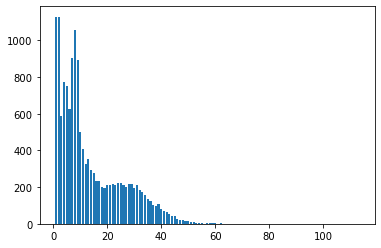

In [27]:
plt.bar(list(map(lambda x: x[0], train_length_hist)),
        list(map(lambda x: x[1], train_length_hist)))

We create bins of sentences of the same length. This is to avoid padding

In [28]:
training_bins = []
for bin in train_length_hist:
    training_bins += [training_set_sorted[:bin[1]]]
    training_set_sorted = training_set_sorted[bin[1]:]

## Training the Model

We now create a generator to generate batches of sentences with the same length

In [29]:
def minibatch_generator(dataset):
    # We take the sentences of the same length
    for sentence_bin in dataset:
        # The number of batches. 
        batch_cnt = int(np.ceil((len(sentence_bin) / BATCH_SIZE)))
        # We create batches of BATCH_SIZE
        for j in range(batch_cnt):
            char_batch = []
            token_batch = []
            label_batch = []
            for sentence in sentence_bin[j*BATCH_SIZE:(j+1)*BATCH_SIZE]:
                tokens, chars, labels = sentence
                char_batch.append(chars)
                token_batch.append(tokens)
                label_batch.append(labels)
            label_batch = list(map(lambda x: np.transpose([x]), label_batch))
            label_batch = to_categorical(label_batch, num_classes=len(ner))
            yield  np.asarray(char_batch), np.asarray(token_batch), label_batch

In [30]:
model.metrics_names

[]

In [31]:
def predict(X_char_idx, X_word_idx, model, idx2pos, default_tag='O'):
    """
    Function to predict the test set and converts the indices to symbols
    """

    Y_pred_vect = []
    for x_char, x_word in zip(X_char_idx, X_word_idx):
        y_pred_vect = model.predict([np.array([x_char]),
                                          np.array([x_word])])[0]
        Y_pred_vect += [y_pred_vect]

    # print('Y_test_pred_vect', Y_test_pred_vect[:2])
    # Convert to POS or NER idx to symbols
    Y_pred = []
    for y_pred_vect in Y_pred_vect:
        pos_idx = np.argmax(y_pred_vect, axis=-1)
        # print('POS_IDX', pos_idx)
        # We convert the indices into symbols
        # If the symbol does not exist, we tag the word with O, the default tag
        pos_cat = list(map(lambda x: idx2pos.get(x, default_tag), pos_idx))
        # We add a sanity check if the classifier has predicted a nonvalid tag.
        # This could only be the padding index: 0
        for pos in pos_idx:
            if pos not in idx2pos:
                print('Bad, should not occur:', pos)
                print((-y_pred_vect).argsort())
                print('Bad, should not occur:', y_pred_vect)
        Y_pred += [pos_cat]
    return Y_pred

With the next function, we format the words, the named entity tags, and the predicted named entity tags so that we can evaluate them. It necessary converts them to the IOBES tagset.

In [32]:
def format_conll(X_words, Y, Y_hat):
    total_words = 0
    correct = 0
    total_ukn = 0
    correct_ukn = 0
    conll_pred_corpus = ''
    
    for sent_nbr, y_vect_hat in enumerate(Y_hat):
        for word_nbr, y_hat in enumerate(y_vect_hat):
            unknown_word = False
            # y is the correct named entity tag
            y = Y[sent_nbr][word_nbr]
            if ANNOTATION == 'IOBES':
                if y[0] == 'S':
                    y = 'B' + y[1:]
                if y[0] == 'E':
                    y = 'I' + y[1:]
                if y_hat[0] == 'S':
                    y_hat = 'B' + y_hat[1:]
                if y_hat[0] == 'E':
                    y_hat = 'I' + y_hat[1:]
            line = ' '.join([X_words[sent_nbr][word_nbr],
                                     y, y_hat])
            line += '\n'
            total_words += 1
            conll_pred_corpus += line
            #file.write(line)
            # The word is not in the dictionary
            if X_words[sent_nbr][word_nbr] not in word2idx:
                total_ukn += 1
                unknown_word = True
            if y_hat == y:
                correct += 1
                if unknown_word:
                    correct_ukn += 1
        conll_pred_corpus += '\n'
        #file.write('\n')
    print('total %d, correct %d, accuracy %f' % (total_words, correct, correct / total_words))
    if total_ukn != 0:
        print('total unknown %d, correct %d, accuracy %f' % (total_ukn, correct_ukn, correct_ukn / total_ukn))
    return conll_pred_corpus

In [33]:
for epoch in range(EPOCHS):    
    print("Epoch {}/{}".format(epoch + 1, EPOCHS))
    for i, batch in tqdm(enumerate(minibatch_generator(training_bins))):
        char_batch, token_batch, label_batch = batch  
        loss = model.train_on_batch([char_batch, token_batch], 
                                    label_batch)

    # We evaluate the dev set
    print('CoNLL score dev set')
    Y_dev_hat = predict(X_dev_char_idx, X_dev_word_idx, model, idx2ner)
    conll_dev_pred = format_conll(X_dev_word_cat, Y_dev_cat, Y_dev_hat)
    
    signature = '_' + str(CHAR_DROPOUT) + '_' + str(DROPOUT_RATE_PRE) + '_' +\
    str(RECURRENT_DROPOUT) + '_' + str(DROPOUT_RATE) + '_' + str(DROPOUT_RATE_POST) + '_'
    
    outfile = 'results/' + 'dev' + signature + '.out'
    with open(outfile, 'w') as file:
        file.write(conll_dev_pred)
    print(os.popen('perl -w conlleval.pl <' + outfile).read())
    
    # We evaluate the test set
    print('CoNLL score test set')
    Y_test_hat = predict(X_test_char_idx, X_test_word_idx, model, idx2ner)
    conll_test_pred = format_conll(X_test_word_cat, Y_test_cat, Y_test_hat)
    
    outfile = 'results/' + 'test' + signature + '.out'
    with open(outfile, 'w') as file:
        file.write(conll_test_pred)
    print(os.popen('perl -w conlleval.pl <' + outfile).read())

0it [00:00, ?it/s]

Epoch 1/80


6it [00:13,  2.41s/it]

7it [00:15,  2.55s/it]

8it [00:18,  2.64s/it]

9it [00:21,  2.80s/it]

10it [00:24,  2.86s/it]

11it [00:28,  3.03s/it]

12it [00:31,  2.96s/it]

13it [00:34,  2.99s/it]

14it [00:37,  2.97s/it]

15it [00:40,  2.95s/it]

16it [00:43,  3.02s/it]

18it [00:46,  2.19s/it]

19it [00:49,  2.49s/it]

20it [00:52,  2.60s/it]

21it [00:55,  2.70s/it]

22it [00:58,  2.79s/it]

23it [01:01,  2.84s/it]

24it [01:04,  2.83s/it]

25it [01:07,  2.82s/it]

26it [01:09,  2.82s/it]

27it [01:12,  2.82s/it]

28it [01:15,  2.96s/it]

29it [01:18,  2.93s/it]

30it [01:21,  2.91s/it]

31it [01:24,  2.89s/it]

32it [01:27,  2.92s/it]

33it [01:30,  2.92s/it]

34it [01:33,  2.88s/it]

35it [01:35,  2.86s/it]

36it [01:38,  2.85s/it]

37it [01:41,  2.90s/it]

38it [01:44,  2.90s/it]

39it [01:48,  3.17s/it]

40it [01:51,  3.09s/it]

41it [01:54,  3.03s/it]

42it [01:57,  3.03s/it]

43it [02:00,  3.00s/it]

44it [02:03,  2.98s/it]

45it [02:06,  2.97s/it]

46it [02:09,  2.96s/it]

47it [02:12,  2.98s/it]

48it [02:14,  2.95s/it]

49it [02:17,  2.92s/it]

50it [02:20,  2.88s/it]

51it [02:23,  2.88s/it]

52it [02:27,  3.15s/it]

53it [02:30,  3.05s/it]

54it [02:33,  3.02s/it]

55it [02:35,  2.97s/it]

56it [02:38,  2.91s/it]

57it [02:41,  2.91s/it]

58it [02:44,  2.88s/it]

59it [02:47,  2.92s/it]

60it [02:50,  2.89s/it]

61it [02:52,  2.83s/it]

62it [02:55,  2.81s/it]

63it [02:58,  2.79s/it]

64it [03:01,  2.76s/it]

65it [03:03,  2.78s/it]

66it [03:06,  2.80s/it]

67it [03:09,  2.81s/it]

68it [03:12,  2.84s/it]

69it [03:16,  3.15s/it]

70it [03:19,  3.07s/it]

71it [03:21,  2.95s/it]

72it [03:24,  2.85s/it]

73it [03:27,  2.84s/it]

74it [03:30,  2.81s/it]

75it [03:32,  2.76s/it]

76it [03:35,  2.84s/it]

CoNLL score dev set


total 51578, correct 45247, accuracy 0.877254
total unknown 713, correct 530, accuracy 0.743338
processed 51578 tokens with 5942 phrases; found: 2054 phrases; correct: 1507.
accuracy:  87.73%; precision:  73.37%; recall:  25.36%; FB1:  37.69
              LOC: precision:  91.01%; recall:  34.73%; FB1:  50.28  701
             MISC: precision:  70.83%; recall:   1.84%; FB1:   3.59  24
              ORG: precision:  63.59%; recall:  10.29%; FB1:  17.72  217
              PER: precision:  64.21%; recall:  38.76%; FB1:  48.34  1112

CoNLL score test set
total 46666, correct 40527, accuracy 0.868448
total unknown 1143, correct 884, accuracy 0.773403


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 2009 phrases; correct: 1301.
accuracy:  86.84%; precision:  64.76%; recall:  23.03%; FB1:  33.98
              LOC: precision:  82.08%; recall:  32.67%; FB1:  46.74  664
             MISC: precision:  62.50%; recall:   0.71%; FB1:   1.41  8
              ORG: precision:  36.49%; recall:   8.13%; FB1:  13.29  370
              PER: precision:  63.70%; recall:  38.10%; FB1:  47.68  967

Epoch 2/80


76it [00:22,  3.41it/s]


CoNLL score dev set
total 51578, correct 46048, accuracy 0.892784
total unknown 713, correct 553, accuracy 0.775596
processed 51578 tokens with 5942 phrases; found: 2650 phrases; correct: 2124.
accuracy:  89.28%; precision:  80.15%; recall:  35.75%; FB1:  49.44
              LOC: precision:  88.91%; recall:  43.66%; FB1:  58.56  902
             MISC: precision:  82.76%; recall:   7.81%; FB1:  14.27  87
              ORG: precision:  72.62%; recall:  18.79%; FB1:  29.86  347
              PER: precision:  75.95%; recall:  54.18%; FB1:  63.24  1314

CoNLL score test set
total 46666, correct 41294, accuracy 0.884884
total unknown 1143, correct 906, accuracy 0.792651


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 2623 phrases; correct: 1908.
accuracy:  88.49%; precision:  72.74%; recall:  33.78%; FB1:  46.14
              LOC: precision:  83.02%; recall:  44.54%; FB1:  57.98  895
             MISC: precision:  75.86%; recall:   6.27%; FB1:  11.58  58
              ORG: precision:  50.00%; recall:  16.80%; FB1:  25.15  558
              PER: precision:  75.72%; recall:  52.07%; FB1:  61.71  1112

Epoch 3/80


76it [00:22,  3.45it/s]


CoNLL score dev set
total 51578, correct 47506, accuracy 0.921052
total unknown 713, correct 587, accuracy 0.823282
processed 51578 tokens with 5942 phrases; found: 4108 phrases; correct: 3251.
accuracy:  92.11%; precision:  79.14%; recall:  54.71%; FB1:  64.70
              LOC: precision:  84.92%; recall:  62.55%; FB1:  72.04  1353
             MISC: precision:  78.21%; recall:  26.46%; FB1:  39.55  312
              ORG: precision:  63.26%; recall:  37.36%; FB1:  46.98  792
              PER: precision:  82.19%; recall:  73.67%; FB1:  77.70  1651

CoNLL score test set
total 46666, correct 42658, accuracy 0.914113
total unknown 1143, correct 971, accuracy 0.849519


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 4244 phrases; correct: 3031.
accuracy:  91.41%; precision:  71.42%; recall:  53.67%; FB1:  61.28
              LOC: precision:  79.75%; recall:  62.11%; FB1:  69.83  1299
             MISC: precision:  69.40%; recall:  27.78%; FB1:  39.67  281
              ORG: precision:  53.21%; recall:  39.98%; FB1:  45.65  1248
              PER: precision:  80.23%; recall:  70.25%; FB1:  74.91  1416

Epoch 4/80


76it [00:22,  3.33it/s]


CoNLL score dev set
total 51578, correct 48165, accuracy 0.933828
total unknown 713, correct 621, accuracy 0.870968
processed 51578 tokens with 5942 phrases; found: 4578 phrases; correct: 3761.
accuracy:  93.38%; precision:  82.15%; recall:  63.30%; FB1:  71.50
              LOC: precision:  88.82%; recall:  69.62%; FB1:  78.06  1440
             MISC: precision:  81.22%; recall:  34.71%; FB1:  48.63  394
              ORG: precision:  68.17%; recall:  46.16%; FB1:  55.05  908
              PER: precision:  84.04%; recall:  83.77%; FB1:  83.90  1836

CoNLL score test set
total 46666, correct 43345, accuracy 0.928835
total unknown 1143, correct 1000, accuracy 0.874891


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 4526 phrases; correct: 3521.
accuracy:  92.88%; precision:  77.79%; recall:  62.34%; FB1:  69.22
              LOC: precision:  83.47%; recall:  66.91%; FB1:  74.28  1337
             MISC: precision:  70.89%; recall:  35.04%; FB1:  46.90  347
              ORG: precision:  67.04%; recall:  50.21%; FB1:  57.42  1244
              PER: precision:  82.92%; recall:  81.94%; FB1:  82.43  1598

Epoch 5/80


76it [00:22,  3.32it/s]


CoNLL score dev set
total 51578, correct 48912, accuracy 0.948311
total unknown 713, correct 619, accuracy 0.868163
processed 51578 tokens with 5942 phrases; found: 5244 phrases; correct: 4312.
accuracy:  94.83%; precision:  82.23%; recall:  72.57%; FB1:  77.10
              LOC: precision:  86.36%; recall:  83.40%; FB1:  84.85  1774
             MISC: precision:  80.43%; recall:  48.16%; FB1:  60.24  552
              ORG: precision:  67.98%; recall:  59.06%; FB1:  63.21  1165
              PER: precision:  88.08%; recall:  83.82%; FB1:  85.90  1753

CoNLL score test set
total 46666, correct 44044, accuracy 0.943813
total unknown 1143, correct 996, accuracy 0.871391


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5203 phrases; correct: 4088.
accuracy:  94.38%; precision:  78.57%; recall:  72.38%; FB1:  75.35
              LOC: precision:  82.43%; recall:  81.83%; FB1:  82.13  1656
             MISC: precision:  73.14%; recall:  50.43%; FB1:  59.70  484
              ORG: precision:  68.75%; recall:  64.12%; FB1:  66.36  1549
              PER: precision:  86.13%; recall:  80.64%; FB1:  83.30  1514

Epoch 6/80


76it [00:22,  3.33it/s]


CoNLL score dev set
total 51578, correct 49446, accuracy 0.958665
total unknown 713, correct 643, accuracy 0.901823
processed 51578 tokens with 5942 phrases; found: 5761 phrases; correct: 4738.
accuracy:  95.87%; precision:  82.24%; recall:  79.74%; FB1:  80.97
              LOC: precision:  89.96%; recall:  85.85%; FB1:  87.86  1753
             MISC: precision:  82.45%; recall:  57.05%; FB1:  67.44  638
              ORG: precision:  65.70%; recall:  72.86%; FB1:  69.09  1487
              PER: precision:  88.05%; recall:  90.01%; FB1:  89.02  1883

CoNLL score test set
total 46666, correct 44415, accuracy 0.951764
total unknown 1143, correct 1016, accuracy 0.888889


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5637 phrases; correct: 4430.
accuracy:  95.18%; precision:  78.59%; recall:  78.43%; FB1:  78.51
              LOC: precision:  85.93%; recall:  83.51%; FB1:  84.71  1621
             MISC: precision:  73.72%; recall:  55.56%; FB1:  63.36  529
              ORG: precision:  66.79%; recall:  74.71%; FB1:  70.53  1858
              PER: precision:  86.31%; recall:  86.95%; FB1:  86.63  1629

Epoch 7/80


76it [00:21,  3.46it/s]


CoNLL score dev set
total 51578, correct 49726, accuracy 0.964093
total unknown 713, correct 644, accuracy 0.903226
processed 51578 tokens with 5942 phrases; found: 6076 phrases; correct: 4968.
accuracy:  96.41%; precision:  81.76%; recall:  83.61%; FB1:  82.68
              LOC: precision:  91.15%; recall:  89.17%; FB1:  90.15  1797
             MISC: precision:  81.82%; recall:  67.35%; FB1:  73.88  759
              ORG: precision:  64.96%; recall:  79.64%; FB1:  71.56  1644
              PER: precision:  87.47%; recall:  89.09%; FB1:  88.27  1876

CoNLL score test set
total 46666, correct 44491, accuracy 0.953392
total unknown 1143, correct 1021, accuracy 0.893263


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5922 phrases; correct: 4566.
accuracy:  95.34%; precision:  77.10%; recall:  80.84%; FB1:  78.93
              LOC: precision:  86.62%; recall:  87.71%; FB1:  87.16  1689
             MISC: precision:  69.08%; recall:  61.11%; FB1:  64.85  621
              ORG: precision:  65.00%; recall:  78.93%; FB1:  71.29  2017
              PER: precision:  85.45%; recall:  84.29%; FB1:  84.87  1595

Epoch 8/80


76it [00:21,  3.54it/s]


CoNLL score dev set
total 51578, correct 49623, accuracy 0.962096
total unknown 713, correct 646, accuracy 0.906031
processed 51578 tokens with 5942 phrases; found: 6332 phrases; correct: 5079.
accuracy:  96.21%; precision:  80.21%; recall:  85.48%; FB1:  82.76
              LOC: precision:  94.11%; recall:  87.81%; FB1:  90.85  1714
             MISC: precision:  83.80%; recall:  64.53%; FB1:  72.92  710
              ORG: precision:  58.25%; recall:  86.58%; FB1:  69.65  1993
              PER: precision:  89.30%; recall:  92.83%; FB1:  91.03  1915

CoNLL score test set
total 46666, correct 44385, accuracy 0.951121
total unknown 1143, correct 1028, accuracy 0.899388


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 6149 phrases; correct: 4707.
accuracy:  95.11%; precision:  76.55%; recall:  83.34%; FB1:  79.80
              LOC: precision:  90.68%; recall:  85.73%; FB1:  88.14  1577
             MISC: precision:  76.28%; recall:  61.40%; FB1:  68.03  565
              ORG: precision:  59.09%; recall:  84.89%; FB1:  69.68  2386
              PER: precision:  88.59%; recall:  88.81%; FB1:  88.70  1621

Epoch 9/80


76it [00:22,  3.44it/s]


CoNLL score dev set
total 51578, correct 49737, accuracy 0.964306
total unknown 713, correct 639, accuracy 0.896213
processed 51578 tokens with 5942 phrases; found: 6278 phrases; correct: 5083.
accuracy:  96.43%; precision:  80.97%; recall:  85.54%; FB1:  83.19
              LOC: precision:  92.49%; recall:  89.17%; FB1:  90.80  1771
             MISC: precision:  83.97%; recall:  69.31%; FB1:  75.94  761
              ORG: precision:  60.56%; recall:  85.98%; FB1:  71.06  1904
              PER: precision:  89.74%; recall:  89.74%; FB1:  89.74  1842

CoNLL score test set
total 46666, correct 44406, accuracy 0.951571
total unknown 1143, correct 1020, accuracy 0.892388


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 6129 phrases; correct: 4652.
accuracy:  95.16%; precision:  75.90%; recall:  82.37%; FB1:  79.00
              LOC: precision:  88.22%; recall:  87.11%; FB1:  87.66  1647
             MISC: precision:  72.73%; recall:  63.82%; FB1:  67.98  616
              ORG: precision:  60.24%; recall:  84.65%; FB1:  70.39  2334
              PER: precision:  87.79%; recall:  83.18%; FB1:  85.42  1532

Epoch 10/80


76it [00:22,  3.42it/s]


CoNLL score dev set
total 51578, correct 50015, accuracy 0.969696
total unknown 713, correct 643, accuracy 0.901823
processed 51578 tokens with 5942 phrases; found: 6259 phrases; correct: 5225.
accuracy:  96.97%; precision:  83.48%; recall:  87.93%; FB1:  85.65
              LOC: precision:  93.88%; recall:  90.26%; FB1:  92.03  1766
             MISC: precision:  76.57%; recall:  74.08%; FB1:  75.30  892
              ORG: precision:  69.68%; recall:  85.01%; FB1:  76.59  1636
              PER: precision:  88.75%; recall:  94.68%; FB1:  91.62  1965

CoNLL score test set
total 46666, correct 44696, accuracy 0.957785
total unknown 1143, correct 1036, accuracy 0.906387


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 6080 phrases; correct: 4834.
accuracy:  95.78%; precision:  79.51%; recall:  85.59%; FB1:  82.44
              LOC: precision:  90.31%; recall:  87.71%; FB1:  88.99  1620
             MISC: precision:  62.70%; recall:  68.23%; FB1:  65.35  764
              ORG: precision:  69.95%; recall:  85.19%; FB1:  76.82  2023
              PER: precision:  88.28%; recall:  91.34%; FB1:  89.79  1673

Epoch 11/80


76it [00:21,  3.53it/s]


CoNLL score dev set
total 51578, correct 49826, accuracy 0.966032
total unknown 713, correct 630, accuracy 0.883590
processed 51578 tokens with 5942 phrases; found: 6256 phrases; correct: 5108.
accuracy:  96.60%; precision:  81.65%; recall:  85.96%; FB1:  83.75
              LOC: precision:  97.44%; recall:  84.92%; FB1:  90.75  1601
             MISC: precision:  81.57%; recall:  70.07%; FB1:  75.38  792
              ORG: precision:  60.69%; recall:  89.11%; FB1:  72.21  1969
              PER: precision:  90.13%; recall:  92.67%; FB1:  91.38  1894

CoNLL score test set
total 46666, correct 44501, accuracy 0.953606
total unknown 1143, correct 1023, accuracy 0.895013


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 6074 phrases; correct: 4686.
accuracy:  95.36%; precision:  77.15%; recall:  82.97%; FB1:  79.95
              LOC: precision:  94.50%; recall:  82.37%; FB1:  88.02  1454
             MISC: precision:  71.29%; recall:  64.39%; FB1:  67.66  634
              ORG: precision:  61.04%; recall:  88.74%; FB1:  72.33  2415
              PER: precision:  88.22%; recall:  85.71%; FB1:  86.95  1571

Epoch 12/80


76it [00:22,  3.44it/s]


CoNLL score dev set
total 51578, correct 49861, accuracy 0.966711
total unknown 713, correct 635, accuracy 0.890603
processed 51578 tokens with 5942 phrases; found: 6291 phrases; correct: 5119.
accuracy:  96.67%; precision:  81.37%; recall:  86.15%; FB1:  83.69
              LOC: precision:  96.38%; recall:  85.63%; FB1:  90.69  1632
             MISC: precision:  83.85%; recall:  68.11%; FB1:  75.16  749
              ORG: precision:  58.96%; recall:  90.08%; FB1:  71.27  2049
              PER: precision:  91.89%; recall:  92.83%; FB1:  92.36  1861

CoNLL score test set
total 46666, correct 44646, accuracy 0.956714
total unknown 1143, correct 1018, accuracy 0.890639


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 6093 phrases; correct: 4726.
accuracy:  95.67%; precision:  77.56%; recall:  83.68%; FB1:  80.50
              LOC: precision:  94.02%; recall:  82.97%; FB1:  88.15  1472
             MISC: precision:  71.95%; recall:  62.11%; FB1:  66.67  606
              ORG: precision:  60.55%; recall:  90.55%; FB1:  72.57  2484
              PER: precision:  91.57%; recall:  86.70%; FB1:  89.07  1531

Epoch 13/80


76it [00:23,  3.24it/s]


CoNLL score dev set
total 51578, correct 50426, accuracy 0.977665
total unknown 713, correct 637, accuracy 0.893408
processed 51578 tokens with 5942 phrases; found: 6088 phrases; correct: 5301.
accuracy:  97.77%; precision:  87.07%; recall:  89.21%; FB1:  88.13
              LOC: precision:  96.18%; recall:  90.47%; FB1:  93.24  1728
             MISC: precision:  86.77%; recall:  72.56%; FB1:  79.03  771
              ORG: precision:  72.02%; recall:  91.35%; FB1:  80.54  1701
              PER: precision:  92.43%; recall:  94.73%; FB1:  93.57  1888

CoNLL score test set
total 46666, correct 45191, accuracy 0.968392
total unknown 1143, correct 1031, accuracy 0.902012


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5865 phrases; correct: 4884.
accuracy:  96.84%; precision:  83.27%; recall:  86.47%; FB1:  84.84
              LOC: precision:  92.93%; recall:  88.25%; FB1:  90.53  1584
             MISC: precision:  73.06%; recall:  64.53%; FB1:  68.53  620
              ORG: precision:  71.90%; recall:  90.73%; FB1:  80.22  2096
              PER: precision:  92.78%; recall:  89.80%; FB1:  91.26  1565

Epoch 14/80


76it [00:21,  3.59it/s]


CoNLL score dev set
total 51578, correct 50469, accuracy 0.978499
total unknown 713, correct 650, accuracy 0.911641
processed 51578 tokens with 5942 phrases; found: 6130 phrases; correct: 5371.
accuracy:  97.85%; precision:  87.62%; recall:  90.39%; FB1:  88.98
              LOC: precision:  94.94%; recall:  92.87%; FB1:  93.89  1797
             MISC: precision:  82.86%; recall:  75.49%; FB1:  79.00  840
              ORG: precision:  78.52%; recall:  89.71%; FB1:  83.75  1532
              PER: precision:  90.06%; recall:  95.87%; FB1:  92.87  1961

CoNLL score test set
total 46666, correct 45196, accuracy 0.968500
total unknown 1143, correct 1046, accuracy 0.915136


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5917 phrases; correct: 4960.
accuracy:  96.85%; precision:  83.83%; recall:  87.82%; FB1:  85.78
              LOC: precision:  90.43%; recall:  90.11%; FB1:  90.27  1662
             MISC: precision:  68.44%; recall:  67.95%; FB1:  68.19  697
              ORG: precision:  78.37%; recall:  88.98%; FB1:  83.34  1886
              PER: precision:  89.83%; recall:  92.89%; FB1:  91.33  1672

Epoch 15/80


76it [00:20,  3.65it/s]


CoNLL score dev set
total 51578, correct 50376, accuracy 0.976695
total unknown 713, correct 642, accuracy 0.900421
processed 51578 tokens with 5942 phrases; found: 6159 phrases; correct: 5311.
accuracy:  97.67%; precision:  86.23%; recall:  89.38%; FB1:  87.78
              LOC: precision:  95.02%; recall:  91.45%; FB1:  93.20  1768
             MISC: precision:  85.42%; recall:  76.25%; FB1:  80.57  823
              ORG: precision:  74.22%; recall:  89.11%; FB1:  80.99  1610
              PER: precision:  88.51%; recall:  94.08%; FB1:  91.21  1958

CoNLL score test set
total 46666, correct 45017, accuracy 0.964664
total unknown 1143, correct 1023, accuracy 0.895013


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5953 phrases; correct: 4860.
accuracy:  96.47%; precision:  81.64%; recall:  86.05%; FB1:  83.79
              LOC: precision:  90.61%; recall:  89.09%; FB1:  89.84  1640
             MISC: precision:  70.53%; recall:  68.52%; FB1:  69.51  682
              ORG: precision:  73.63%; recall:  88.26%; FB1:  80.28  1991
              PER: precision:  87.01%; recall:  88.25%; FB1:  87.63  1640

Epoch 16/80


76it [00:20,  3.64it/s]


CoNLL score dev set
total 51578, correct 50453, accuracy 0.978188
total unknown 713, correct 640, accuracy 0.897616
processed 51578 tokens with 5942 phrases; found: 6084 phrases; correct: 5333.
accuracy:  97.82%; precision:  87.66%; recall:  89.75%; FB1:  88.69
              LOC: precision:  96.18%; recall:  91.78%; FB1:  93.93  1753
             MISC: precision:  89.09%; recall:  76.14%; FB1:  82.11  788
              ORG: precision:  71.33%; recall:  92.02%; FB1:  80.36  1730
              PER: precision:  94.37%; recall:  92.89%; FB1:  93.63  1813

CoNLL score test set
total 46666, correct 45173, accuracy 0.968007
total unknown 1143, correct 1027, accuracy 0.898513


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5866 phrases; correct: 4887.
accuracy:  96.80%; precision:  83.31%; recall:  86.53%; FB1:  84.89
              LOC: precision:  92.37%; recall:  88.55%; FB1:  90.42  1599
             MISC: precision:  75.90%; recall:  69.09%; FB1:  72.33  639
              ORG: precision:  70.70%; recall:  91.39%; FB1:  79.73  2147
              PER: precision:  95.00%; recall:  87.01%; FB1:  90.83  1481

Epoch 17/80


76it [00:20,  3.64it/s]


CoNLL score dev set
total 51578, correct 50530, accuracy 0.979681
total unknown 713, correct 652, accuracy 0.914446
processed 51578 tokens with 5942 phrases; found: 6056 phrases; correct: 5409.
accuracy:  97.97%; precision:  89.32%; recall:  91.03%; FB1:  90.17
              LOC: precision:  97.41%; recall:  92.27%; FB1:  94.77  1740
             MISC: precision:  87.16%; recall:  81.02%; FB1:  83.98  857
              ORG: precision:  77.51%; recall:  89.71%; FB1:  83.17  1552
              PER: precision:  92.50%; recall:  95.77%; FB1:  94.11  1907

CoNLL score test set
total 46666, correct 45174, accuracy 0.968028
total unknown 1143, correct 1045, accuracy 0.914261


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5858 phrases; correct: 4974.
accuracy:  96.80%; precision:  84.91%; recall:  88.07%; FB1:  86.46
              LOC: precision:  93.15%; recall:  88.85%; FB1:  90.95  1591
             MISC: precision:  70.76%; recall:  71.37%; FB1:  71.06  708
              ORG: precision:  76.89%; recall:  89.52%; FB1:  82.73  1934
              PER: precision:  92.55%; recall:  93.01%; FB1:  92.78  1625

Epoch 18/80


76it [00:21,  3.59it/s]


CoNLL score dev set
total 51578, correct 50631, accuracy 0.981639
total unknown 713, correct 645, accuracy 0.904628
processed 51578 tokens with 5942 phrases; found: 6053 phrases; correct: 5437.
accuracy:  98.16%; precision:  89.82%; recall:  91.50%; FB1:  90.65
              LOC: precision:  96.58%; recall:  93.79%; FB1:  95.17  1784
             MISC: precision:  88.58%; recall:  79.07%; FB1:  83.55  823
              ORG: precision:  77.55%; recall:  91.20%; FB1:  83.82  1577
              PER: precision:  94.28%; recall:  95.66%; FB1:  94.96  1869

CoNLL score test set
total 46666, correct 45266, accuracy 0.970000
total unknown 1143, correct 1043, accuracy 0.912511


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5848 phrases; correct: 4979.
accuracy:  97.00%; precision:  85.14%; recall:  88.16%; FB1:  86.62
              LOC: precision:  91.19%; recall:  90.65%; FB1:  90.92  1658
             MISC: precision:  74.21%; recall:  70.51%; FB1:  72.32  667
              ORG: precision:  76.43%; recall:  89.83%; FB1:  82.59  1952
              PER: precision:  94.21%; recall:  91.53%; FB1:  92.85  1571

Epoch 19/80


76it [00:21,  3.60it/s]


CoNLL score dev set
total 51578, correct 50760, accuracy 0.984141
total unknown 713, correct 660, accuracy 0.925666
processed 51578 tokens with 5942 phrases; found: 5998 phrases; correct: 5499.
accuracy:  98.41%; precision:  91.68%; recall:  92.54%; FB1:  92.11
              LOC: precision:  96.75%; recall:  94.07%; FB1:  95.39  1786
             MISC: precision:  89.25%; recall:  83.73%; FB1:  86.40  865
              ORG: precision:  83.87%; recall:  91.13%; FB1:  87.35  1457
              PER: precision:  94.02%; recall:  96.47%; FB1:  95.23  1890

CoNLL score test set
total 46666, correct 45423, accuracy 0.973364
total unknown 1143, correct 1053, accuracy 0.921260


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5776 phrases; correct: 5039.
accuracy:  97.34%; precision:  87.24%; recall:  89.22%; FB1:  88.22
              LOC: precision:  91.85%; recall:  90.59%; FB1:  91.22  1645
             MISC: precision:  74.75%; recall:  74.64%; FB1:  74.70  701
              ORG: precision:  81.92%; recall:  89.22%; FB1:  85.42  1809
              PER: precision:  93.89%; recall:  94.12%; FB1:  94.01  1621

Epoch 20/80


76it [00:20,  3.70it/s]


CoNLL score dev set
total 51578, correct 50666, accuracy 0.982318
total unknown 713, correct 653, accuracy 0.915849
processed 51578 tokens with 5942 phrases; found: 5978 phrases; correct: 5451.
accuracy:  98.23%; precision:  91.18%; recall:  91.74%; FB1:  91.46
              LOC: precision:  96.35%; recall:  94.72%; FB1:  95.53  1806
             MISC: precision:  88.71%; recall:  81.78%; FB1:  85.10  850
              ORG: precision:  81.30%; recall:  88.81%; FB1:  84.89  1465
              PER: precision:  95.10%; recall:  95.87%; FB1:  95.49  1857

CoNLL score test set
total 46666, correct 45291, accuracy 0.970535
total unknown 1143, correct 1047, accuracy 0.916010


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5775 phrases; correct: 4986.
accuracy:  97.05%; precision:  86.34%; recall:  88.28%; FB1:  87.30
              LOC: precision:  91.53%; recall:  91.31%; FB1:  91.42  1664
             MISC: precision:  74.12%; recall:  72.22%; FB1:  73.16  684
              ORG: precision:  78.91%; recall:  88.32%; FB1:  83.35  1859
              PER: precision:  94.96%; recall:  92.08%; FB1:  93.50  1568

Epoch 21/80


76it [00:20,  3.72it/s]


CoNLL score dev set
total 51578, correct 50652, accuracy 0.982047
total unknown 713, correct 655, accuracy 0.918654
processed 51578 tokens with 5942 phrases; found: 6014 phrases; correct: 5443.
accuracy:  98.20%; precision:  90.51%; recall:  91.60%; FB1:  91.05
              LOC: precision:  95.41%; recall:  93.85%; FB1:  94.62  1807
             MISC: precision:  90.65%; recall:  82.00%; FB1:  86.10  834
              ORG: precision:  83.29%; recall:  88.81%; FB1:  85.96  1430
              PER: precision:  91.20%; recall:  96.20%; FB1:  93.63  1943

CoNLL score test set
total 46666, correct 45348, accuracy 0.971757
total unknown 1143, correct 1048, accuracy 0.916885


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5794 phrases; correct: 5014.
accuracy:  97.18%; precision:  86.54%; recall:  88.77%; FB1:  87.64
              LOC: precision:  91.54%; recall:  91.43%; FB1:  91.48  1666
             MISC: precision:  77.20%; recall:  72.36%; FB1:  74.71  658
              ORG: precision:  81.95%; recall:  88.02%; FB1:  84.88  1784
              PER: precision:  90.09%; recall:  93.94%; FB1:  91.98  1686

Epoch 22/80


76it [00:20,  3.69it/s]


CoNLL score dev set
total 51578, correct 50798, accuracy 0.984877
total unknown 713, correct 656, accuracy 0.920056
processed 51578 tokens with 5942 phrases; found: 5983 phrases; correct: 5508.
accuracy:  98.49%; precision:  92.06%; recall:  92.70%; FB1:  92.38
              LOC: precision:  96.66%; recall:  94.61%; FB1:  95.63  1798
             MISC: precision:  89.99%; recall:  83.84%; FB1:  86.81  859
              ORG: precision:  83.13%; recall:  91.50%; FB1:  87.11  1476
              PER: precision:  95.68%; recall:  96.09%; FB1:  95.88  1850

CoNLL score test set
total 46666, correct 45479, accuracy 0.974564
total unknown 1143, correct 1063, accuracy 0.930009


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5733 phrases; correct: 5029.
accuracy:  97.46%; precision:  87.72%; recall:  89.04%; FB1:  88.38
              LOC: precision:  92.71%; recall:  91.49%; FB1:  92.09  1646
             MISC: precision:  74.93%; recall:  74.07%; FB1:  74.50  694
              ORG: precision:  80.84%; recall:  90.43%; FB1:  85.37  1858
              PER: precision:  96.48%; recall:  91.59%; FB1:  93.97  1535

Epoch 23/80


76it [00:20,  3.70it/s]


CoNLL score dev set
total 51578, correct 50768, accuracy 0.984296
total unknown 713, correct 655, accuracy 0.918654
processed 51578 tokens with 5942 phrases; found: 5972 phrases; correct: 5487.
accuracy:  98.43%; precision:  91.88%; recall:  92.34%; FB1:  92.11
              LOC: precision:  98.14%; recall:  91.83%; FB1:  94.88  1719
             MISC: precision:  90.49%; recall:  83.62%; FB1:  86.92  852
              ORG: precision:  81.48%; recall:  92.54%; FB1:  86.66  1523
              PER: precision:  95.21%; recall:  97.07%; FB1:  96.13  1878

CoNLL score test set
total 46666, correct 45567, accuracy 0.976450
total unknown 1143, correct 1063, accuracy 0.930009


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5712 phrases; correct: 5066.
accuracy:  97.64%; precision:  88.69%; recall:  89.70%; FB1:  89.19
              LOC: precision:  94.95%; recall:  89.09%; FB1:  91.93  1565
             MISC: precision:  78.44%; recall:  74.64%; FB1:  76.50  668
              ORG: precision:  81.03%; recall:  91.57%; FB1:  85.98  1877
              PER: precision:  95.82%; recall:  94.93%; FB1:  95.37  1602

Epoch 24/80


76it [00:20,  3.73it/s]


CoNLL score dev set
total 51578, correct 50882, accuracy 0.986506
total unknown 713, correct 674, accuracy 0.945302
processed 51578 tokens with 5942 phrases; found: 5963 phrases; correct: 5554.
accuracy:  98.65%; precision:  93.14%; recall:  93.47%; FB1:  93.31
              LOC: precision:  95.47%; recall:  96.30%; FB1:  95.88  1853
             MISC: precision:  91.56%; recall:  85.90%; FB1:  88.64  865
              ORG: precision:  88.78%; recall:  89.71%; FB1:  89.24  1355
              PER: precision:  94.71%; recall:  97.18%; FB1:  95.93  1890

CoNLL score test set
total 46666, correct 45665, accuracy 0.978550
total unknown 1143, correct 1074, accuracy 0.939633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5659 phrases; correct: 5070.
accuracy:  97.85%; precision:  89.59%; recall:  89.77%; FB1:  89.68
              LOC: precision:  90.32%; recall:  92.81%; FB1:  91.54  1714
             MISC: precision:  81.59%; recall:  77.64%; FB1:  79.56  668
              ORG: precision:  87.71%; recall:  86.75%; FB1:  87.23  1643
              PER: precision:  94.00%; recall:  94.99%; FB1:  94.49  1634

Epoch 25/80


76it [00:20,  3.70it/s]


CoNLL score dev set
total 51578, correct 50830, accuracy 0.985498
total unknown 713, correct 669, accuracy 0.938289
processed 51578 tokens with 5942 phrases; found: 5954 phrases; correct: 5529.
accuracy:  98.55%; precision:  92.86%; recall:  93.05%; FB1:  92.96
              LOC: precision:  95.92%; recall:  95.92%; FB1:  95.92  1837
             MISC: precision:  90.40%; recall:  85.79%; FB1:  88.04  875
              ORG: precision:  87.20%; recall:  89.41%; FB1:  88.29  1375
              PER: precision:  95.18%; recall:  96.47%; FB1:  95.82  1867

CoNLL score test set
total 46666, correct 45577, accuracy 0.976664
total unknown 1143, correct 1073, accuracy 0.938758


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5687 phrases; correct: 5069.
accuracy:  97.67%; precision:  89.13%; recall:  89.75%; FB1:  89.44
              LOC: precision:  90.55%; recall:  92.45%; FB1:  91.49  1703
             MISC: precision:  79.73%; recall:  76.78%; FB1:  78.23  676
              ORG: precision:  85.26%; recall:  88.14%; FB1:  86.68  1717
              PER: precision:  95.79%; recall:  94.25%; FB1:  95.01  1591

Epoch 26/80


76it [00:20,  3.67it/s]


CoNLL score dev set
total 51578, correct 50797, accuracy 0.984858
total unknown 713, correct 662, accuracy 0.928471
processed 51578 tokens with 5942 phrases; found: 5963 phrases; correct: 5500.
accuracy:  98.49%; precision:  92.24%; recall:  92.56%; FB1:  92.40
              LOC: precision:  94.67%; recall:  96.68%; FB1:  95.66  1876
             MISC: precision:  92.30%; recall:  81.89%; FB1:  86.78  818
              ORG: precision:  84.52%; recall:  90.38%; FB1:  87.35  1434
              PER: precision:  95.75%; recall:  95.39%; FB1:  95.57  1835

CoNLL score test set
total 46666, correct 45521, accuracy 0.975464
total unknown 1143, correct 1062, accuracy 0.929134


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5695 phrases; correct: 5026.
accuracy:  97.55%; precision:  88.25%; recall:  88.99%; FB1:  88.62
              LOC: precision:  89.83%; recall:  92.69%; FB1:  91.24  1721
             MISC: precision:  82.05%; recall:  72.93%; FB1:  77.22  624
              ORG: precision:  82.03%; recall:  89.04%; FB1:  85.39  1803
              PER: precision:  96.25%; recall:  92.08%; FB1:  94.12  1547

Epoch 27/80


76it [00:20,  3.70it/s]


CoNLL score dev set
total 51578, correct 50846, accuracy 0.985808
total unknown 713, correct 672, accuracy 0.942496
processed 51578 tokens with 5942 phrases; found: 5982 phrases; correct: 5535.
accuracy:  98.58%; precision:  92.53%; recall:  93.15%; FB1:  92.84
              LOC: precision:  95.81%; recall:  95.81%; FB1:  95.81  1837
             MISC: precision:  90.18%; recall:  84.71%; FB1:  87.36  866
              ORG: precision:  87.85%; recall:  90.08%; FB1:  88.95  1375
              PER: precision:  93.80%; recall:  96.96%; FB1:  95.36  1904

CoNLL score test set
total 46666, correct 45584, accuracy 0.976814
total unknown 1143, correct 1069, accuracy 0.935258


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5696 phrases; correct: 5066.
accuracy:  97.68%; precision:  88.94%; recall:  89.70%; FB1:  89.32
              LOC: precision:  90.87%; recall:  92.45%; FB1:  91.65  1697
             MISC: precision:  79.76%; recall:  76.35%; FB1:  78.02  672
              ORG: precision:  86.35%; recall:  87.24%; FB1:  86.79  1678
              PER: precision:  93.33%; recall:  95.18%; FB1:  94.24  1649

Epoch 28/80


76it [00:20,  3.65it/s]


CoNLL score dev set
total 51578, correct 50889, accuracy 0.986642
total unknown 713, correct 670, accuracy 0.939691
processed 51578 tokens with 5942 phrases; found: 5947 phrases; correct: 5537.
accuracy:  98.66%; precision:  93.11%; recall:  93.18%; FB1:  93.14
              LOC: precision:  95.68%; recall:  96.46%; FB1:  96.07  1852
             MISC: precision:  92.56%; recall:  82.32%; FB1:  87.14  820
              ORG: precision:  86.49%; recall:  91.65%; FB1:  88.99  1421
              PER: precision:  95.85%; recall:  96.47%; FB1:  96.16  1854

CoNLL score test set
total 46666, correct 45627, accuracy 0.977735
total unknown 1143, correct 1069, accuracy 0.935258


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5676 phrases; correct: 5072.
accuracy:  97.77%; precision:  89.36%; recall:  89.80%; FB1:  89.58
              LOC: precision:  90.22%; recall:  92.87%; FB1:  91.52  1717
             MISC: precision:  82.37%; recall:  73.22%; FB1:  77.53  624
              ORG: precision:  84.20%; recall:  89.22%; FB1:  86.64  1760
              PER: precision:  96.95%; recall:  94.43%; FB1:  95.68  1575

Epoch 29/80


76it [00:20,  3.66it/s]


CoNLL score dev set
total 51578, correct 50871, accuracy 0.986293
total unknown 713, correct 673, accuracy 0.943899
processed 51578 tokens with 5942 phrases; found: 5970 phrases; correct: 5540.
accuracy:  98.63%; precision:  92.80%; recall:  93.23%; FB1:  93.02
              LOC: precision:  95.98%; recall:  96.19%; FB1:  96.08  1841
             MISC: precision:  93.52%; recall:  82.97%; FB1:  87.93  818
              ORG: precision:  85.92%; recall:  91.50%; FB1:  88.62  1428
              PER: precision:  94.58%; recall:  96.69%; FB1:  95.62  1883

CoNLL score test set
total 46666, correct 45618, accuracy 0.977543
total unknown 1143, correct 1068, accuracy 0.934383


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5714 phrases; correct: 5089.
accuracy:  97.75%; precision:  89.06%; recall:  90.10%; FB1:  89.58
              LOC: precision:  90.93%; recall:  92.51%; FB1:  91.71  1697
             MISC: precision:  83.52%; recall:  74.36%; FB1:  78.67  625
              ORG: precision:  84.14%; recall:  89.40%; FB1:  86.69  1765
              PER: precision:  94.59%; recall:  95.18%; FB1:  94.88  1627

Epoch 30/80


76it [00:22,  3.34it/s]


CoNLL score dev set
total 51578, correct 50970, accuracy 0.988212
total unknown 713, correct 681, accuracy 0.955119
processed 51578 tokens with 5942 phrases; found: 5975 phrases; correct: 5596.
accuracy:  98.82%; precision:  93.66%; recall:  94.18%; FB1:  93.92
              LOC: precision:  96.20%; recall:  96.35%; FB1:  96.27  1840
             MISC: precision:  90.63%; recall:  87.09%; FB1:  88.83  886
              ORG: precision:  88.91%; recall:  92.69%; FB1:  90.76  1398
              PER: precision:  96.16%; recall:  96.63%; FB1:  96.40  1851

CoNLL score test set
total 46666, correct 45713, accuracy 0.979578
total unknown 1143, correct 1074, accuracy 0.939633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5701 phrases; correct: 5116.
accuracy:  97.96%; precision:  89.74%; recall:  90.58%; FB1:  90.16
              LOC: precision:  90.96%; recall:  92.87%; FB1:  91.90  1703
             MISC: precision:  80.09%; recall:  77.35%; FB1:  78.70  678
              ORG: precision:  85.67%; recall:  90.01%; FB1:  87.79  1745
              PER: precision:  97.08%; recall:  94.56%; FB1:  95.80  1575

Epoch 31/80


76it [00:22,  3.32it/s]


CoNLL score dev set
total 51578, correct 50936, accuracy 0.987553
total unknown 713, correct 679, accuracy 0.952314
processed 51578 tokens with 5942 phrases; found: 5967 phrases; correct: 5582.
accuracy:  98.76%; precision:  93.55%; recall:  93.94%; FB1:  93.74
              LOC: precision:  97.03%; recall:  96.08%; FB1:  96.55  1819
             MISC: precision:  88.84%; recall:  87.20%; FB1:  88.01  905
              ORG: precision:  90.58%; recall:  91.05%; FB1:  90.81  1348
              PER: precision:  94.56%; recall:  97.29%; FB1:  95.91  1895

CoNLL score test set
total 46666, correct 45630, accuracy 0.977800
total unknown 1143, correct 1078, accuracy 0.943132


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5685 phrases; correct: 5089.
accuracy:  97.78%; precision:  89.52%; recall:  90.10%; FB1:  89.81
              LOC: precision:  92.80%; recall:  91.91%; FB1:  92.35  1652
             MISC: precision:  76.40%; recall:  79.77%; FB1:  78.05  733
              ORG: precision:  87.58%; recall:  87.06%; FB1:  87.32  1651
              PER: precision:  94.00%; recall:  95.86%; FB1:  94.92  1649

Epoch 32/80


76it [00:23,  3.26it/s]


CoNLL score dev set
total 51578, correct 50944, accuracy 0.987708
total unknown 713, correct 677, accuracy 0.949509
processed 51578 tokens with 5942 phrases; found: 5940 phrases; correct: 5568.
accuracy:  98.77%; precision:  93.74%; recall:  93.71%; FB1:  93.72
              LOC: precision:  96.20%; recall:  96.46%; FB1:  96.33  1842
             MISC: precision:  91.17%; recall:  86.23%; FB1:  88.63  872
              ORG: precision:  88.77%; recall:  91.35%; FB1:  90.04  1380
              PER: precision:  96.21%; recall:  96.42%; FB1:  96.31  1846

CoNLL score test set
total 46666, correct 45639, accuracy 0.977993
total unknown 1143, correct 1072, accuracy 0.937883


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5676 phrases; correct: 5082.
accuracy:  97.80%; precision:  89.53%; recall:  89.98%; FB1:  89.76
              LOC: precision:  90.74%; recall:  92.87%; FB1:  91.79  1707
             MISC: precision:  79.31%; recall:  74.79%; FB1:  76.98  662
              ORG: precision:  85.32%; recall:  88.86%; FB1:  87.05  1730
              PER: precision:  97.15%; recall:  94.74%; FB1:  95.93  1577

Epoch 33/80


76it [00:22,  3.33it/s]


CoNLL score dev set
total 51578, correct 50980, accuracy 0.988406
total unknown 713, correct 683, accuracy 0.957924
processed 51578 tokens with 5942 phrases; found: 5928 phrases; correct: 5589.
accuracy:  98.84%; precision:  94.28%; recall:  94.06%; FB1:  94.17
              LOC: precision:  96.93%; recall:  96.41%; FB1:  96.67  1827
             MISC: precision:  91.52%; recall:  87.74%; FB1:  89.59  884
              ORG: precision:  90.38%; recall:  91.13%; FB1:  90.75  1352
              PER: precision:  95.82%; recall:  97.01%; FB1:  96.41  1865

CoNLL score test set
total 46666, correct 45678, accuracy 0.978828
total unknown 1143, correct 1073, accuracy 0.938758


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5644 phrases; correct: 5094.
accuracy:  97.88%; precision:  90.26%; recall:  90.19%; FB1:  90.22
              LOC: precision:  90.85%; recall:  92.87%; FB1:  91.85  1705
             MISC: precision:  80.32%; recall:  79.06%; FB1:  79.68  691
              ORG: precision:  87.66%; recall:  87.24%; FB1:  87.45  1653
              PER: precision:  96.61%; recall:  95.30%; FB1:  95.95  1595

Epoch 34/80


76it [00:23,  3.24it/s]


CoNLL score dev set
total 51578, correct 50940, accuracy 0.987630
total unknown 713, correct 676, accuracy 0.948107
processed 51578 tokens with 5942 phrases; found: 5939 phrases; correct: 5559.
accuracy:  98.76%; precision:  93.60%; recall:  93.55%; FB1:  93.58
              LOC: precision:  97.49%; recall:  95.05%; FB1:  96.25  1791
             MISC: precision:  90.36%; recall:  87.42%; FB1:  88.86  892
              ORG: precision:  87.17%; recall:  92.24%; FB1:  89.64  1419
              PER: precision:  96.35%; recall:  96.09%; FB1:  96.22  1837

CoNLL score test set
total 46666, correct 45592, accuracy 0.976985
total unknown 1143, correct 1073, accuracy 0.938758


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5673 phrases; correct: 5064.
accuracy:  97.70%; precision:  89.26%; recall:  89.66%; FB1:  89.46
              LOC: precision:  93.04%; recall:  91.43%; FB1:  92.23  1639
             MISC: precision:  77.09%; recall:  76.21%; FB1:  76.65  694
              ORG: precision:  83.61%; recall:  90.01%; FB1:  86.69  1788
              PER: precision:  97.23%; recall:  93.32%; FB1:  95.24  1552

Epoch 35/80


76it [00:22,  3.34it/s]


CoNLL score dev set
total 51578, correct 50935, accuracy 0.987533
total unknown 713, correct 679, accuracy 0.952314
processed 51578 tokens with 5942 phrases; found: 5946 phrases; correct: 5565.
accuracy:  98.75%; precision:  93.59%; recall:  93.66%; FB1:  93.62
              LOC: precision:  96.66%; recall:  96.08%; FB1:  96.37  1826
             MISC: precision:  92.41%; recall:  85.79%; FB1:  88.98  856
              ORG: precision:  87.29%; recall:  92.69%; FB1:  89.91  1424
              PER: precision:  95.98%; recall:  95.87%; FB1:  95.93  1840

CoNLL score test set
total 46666, correct 45694, accuracy 0.979171
total unknown 1143, correct 1078, accuracy 0.943132


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5688 phrases; correct: 5117.
accuracy:  97.92%; precision:  89.96%; recall:  90.60%; FB1:  90.28
              LOC: precision:  92.67%; recall:  92.51%; FB1:  92.59  1665
             MISC: precision:  82.05%; recall:  77.49%; FB1:  79.71  663
              ORG: precision:  84.15%; recall:  90.49%; FB1:  87.21  1786
              PER: precision:  97.01%; recall:  94.43%; FB1:  95.71  1574

Epoch 36/80


76it [00:22,  3.40it/s]


CoNLL score dev set
total 51578, correct 50985, accuracy 0.988503
total unknown 713, correct 680, accuracy 0.953717
processed 51578 tokens with 5942 phrases; found: 5929 phrases; correct: 5591.
accuracy:  98.85%; precision:  94.30%; recall:  94.09%; FB1:  94.20
              LOC: precision:  96.76%; recall:  96.03%; FB1:  96.39  1823
             MISC: precision:  90.37%; recall:  87.53%; FB1:  88.93  893
              ORG: precision:  90.93%; recall:  91.95%; FB1:  91.43  1356
              PER: precision:  96.23%; recall:  97.01%; FB1:  96.62  1857

CoNLL score test set
total 46666, correct 45729, accuracy 0.979921
total unknown 1143, correct 1083, accuracy 0.947507


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5639 phrases; correct: 5115.
accuracy:  97.99%; precision:  90.71%; recall:  90.56%; FB1:  90.64
              LOC: precision:  92.49%; recall:  92.27%; FB1:  92.38  1664
             MISC: precision:  79.37%; recall:  79.49%; FB1:  79.43  703
              ORG: precision:  88.00%; recall:  88.32%; FB1:  88.16  1667
              PER: precision:  96.64%; recall:  95.92%; FB1:  96.28  1605

Epoch 37/80


76it [00:21,  3.47it/s]


CoNLL score dev set
total 51578, correct 50997, accuracy 0.988736
total unknown 713, correct 682, accuracy 0.956522
processed 51578 tokens with 5942 phrases; found: 5946 phrases; correct: 5597.
accuracy:  98.87%; precision:  94.13%; recall:  94.19%; FB1:  94.16
              LOC: precision:  95.75%; recall:  96.84%; FB1:  96.29  1858
             MISC: precision:  91.52%; recall:  87.74%; FB1:  89.59  884
              ORG: precision:  90.85%; recall:  91.80%; FB1:  91.32  1355
              PER: precision:  96.16%; recall:  96.53%; FB1:  96.34  1849

CoNLL score test set
total 46666, correct 45689, accuracy 0.979064
total unknown 1143, correct 1080, accuracy 0.944882


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5666 phrases; correct: 5111.
accuracy:  97.91%; precision:  90.20%; recall:  90.49%; FB1:  90.35
              LOC: precision:  90.49%; recall:  93.53%; FB1:  91.98  1724
             MISC: precision:  81.22%; recall:  79.49%; FB1:  80.35  687
              ORG: precision:  87.29%; recall:  88.08%; FB1:  87.68  1676
              PER: precision:  96.90%; recall:  94.62%; FB1:  95.74  1579

Epoch 38/80


76it [00:22,  3.41it/s]


CoNLL score dev set
total 51578, correct 50987, accuracy 0.988542
total unknown 713, correct 685, accuracy 0.960729
processed 51578 tokens with 5942 phrases; found: 5954 phrases; correct: 5605.
accuracy:  98.85%; precision:  94.14%; recall:  94.33%; FB1:  94.23
              LOC: precision:  97.04%; recall:  96.46%; FB1:  96.75  1826
             MISC: precision:  90.74%; recall:  88.18%; FB1:  89.44  896
              ORG: precision:  90.60%; recall:  92.02%; FB1:  91.31  1362
              PER: precision:  95.51%; recall:  96.96%; FB1:  96.23  1870

CoNLL score test set
total 46666, correct 45693, accuracy 0.979150
total unknown 1143, correct 1078, accuracy 0.943132


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5689 phrases; correct: 5126.
accuracy:  97.91%; precision:  90.10%; recall:  90.76%; FB1:  90.43
              LOC: precision:  92.07%; recall:  92.63%; FB1:  92.35  1678
             MISC: precision:  78.87%; recall:  79.20%; FB1:  79.03  705
              ORG: precision:  86.84%; recall:  88.98%; FB1:  87.90  1702
              PER: precision:  96.45%; recall:  95.67%; FB1:  96.06  1604

Epoch 39/80


76it [00:22,  3.45it/s]


CoNLL score dev set
total 51578, correct 50989, accuracy 0.988580
total unknown 713, correct 685, accuracy 0.960729
processed 51578 tokens with 5942 phrases; found: 5945 phrases; correct: 5606.
accuracy:  98.86%; precision:  94.30%; recall:  94.35%; FB1:  94.32
              LOC: precision:  96.21%; recall:  96.73%; FB1:  96.47  1847
             MISC: precision:  91.73%; recall:  89.05%; FB1:  90.37  895
              ORG: precision:  90.94%; recall:  91.35%; FB1:  91.15  1347
              PER: precision:  96.07%; recall:  96.80%; FB1:  96.43  1856

CoNLL score test set
total 46666, correct 45652, accuracy 0.978271
total unknown 1143, correct 1073, accuracy 0.938758


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5686 phrases; correct: 5105.
accuracy:  97.83%; precision:  89.78%; recall:  90.39%; FB1:  90.08
              LOC: precision:  91.46%; recall:  92.45%; FB1:  91.95  1686
             MISC: precision:  79.21%; recall:  79.77%; FB1:  79.49  707
              ORG: precision:  86.20%; recall:  88.02%; FB1:  87.10  1696
              PER: precision:  96.49%; recall:  95.30%; FB1:  95.89  1597

Epoch 40/80


76it [00:22,  3.36it/s]


CoNLL score dev set
total 51578, correct 50998, accuracy 0.988755
total unknown 713, correct 684, accuracy 0.959327
processed 51578 tokens with 5942 phrases; found: 5938 phrases; correct: 5601.
accuracy:  98.88%; precision:  94.32%; recall:  94.26%; FB1:  94.29
              LOC: precision:  96.25%; recall:  96.41%; FB1:  96.33  1840
             MISC: precision:  88.36%; recall:  90.56%; FB1:  89.45  945
              ORG: precision:  93.32%; recall:  90.68%; FB1:  91.98  1303
              PER: precision:  96.16%; recall:  96.58%; FB1:  96.37  1850

CoNLL score test set
total 46666, correct 45672, accuracy 0.978700
total unknown 1143, correct 1076, accuracy 0.941382


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5642 phrases; correct: 5077.
accuracy:  97.87%; precision:  89.99%; recall:  89.89%; FB1:  89.94
              LOC: precision:  90.27%; recall:  93.41%; FB1:  91.81  1726
             MISC: precision:  74.71%; recall:  82.05%; FB1:  78.21  771
              ORG: precision:  90.35%; recall:  84.59%; FB1:  87.38  1555
              PER: precision:  96.73%; recall:  95.11%; FB1:  95.92  1590

Epoch 41/80


76it [00:23,  3.26it/s]


CoNLL score dev set
total 51578, correct 50986, accuracy 0.988522
total unknown 713, correct 682, accuracy 0.956522
processed 51578 tokens with 5942 phrases; found: 5947 phrases; correct: 5594.
accuracy:  98.85%; precision:  94.06%; recall:  94.14%; FB1:  94.10
              LOC: precision:  96.81%; recall:  95.92%; FB1:  96.36  1820
             MISC: precision:  91.55%; recall:  88.18%; FB1:  89.83  888
              ORG: precision:  89.15%; recall:  92.54%; FB1:  90.82  1392
              PER: precision:  96.26%; recall:  96.53%; FB1:  96.39  1847

CoNLL score test set
total 46666, correct 45687, accuracy 0.979021
total unknown 1143, correct 1075, accuracy 0.940507


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5679 phrases; correct: 5124.
accuracy:  97.90%; precision:  90.23%; recall:  90.72%; FB1:  90.47
              LOC: precision:  92.60%; recall:  92.27%; FB1:  92.43  1662
             MISC: precision:  79.40%; recall:  79.06%; FB1:  79.23  699
              ORG: precision:  86.03%; recall:  89.70%; FB1:  87.83  1732
              PER: precision:  97.10%; recall:  95.24%; FB1:  96.16  1586

Epoch 42/80


76it [00:23,  3.28it/s]


CoNLL score dev set
total 51578, correct 50992, accuracy 0.988639
total unknown 713, correct 685, accuracy 0.960729
processed 51578 tokens with 5942 phrases; found: 5959 phrases; correct: 5605.
accuracy:  98.86%; precision:  94.06%; recall:  94.33%; FB1:  94.19
              LOC: precision:  96.14%; recall:  96.30%; FB1:  96.22  1840
             MISC: precision:  89.75%; recall:  88.29%; FB1:  89.01  907
              ORG: precision:  91.97%; recall:  91.35%; FB1:  91.66  1332
              PER: precision:  95.59%; recall:  97.56%; FB1:  96.56  1880

CoNLL score test set
total 46666, correct 45707, accuracy 0.979450
total unknown 1143, correct 1077, accuracy 0.942257


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5666 phrases; correct: 5113.
accuracy:  97.94%; precision:  90.24%; recall:  90.53%; FB1:  90.38
              LOC: precision:  91.04%; recall:  93.17%; FB1:  92.09  1707
             MISC: precision:  78.66%; recall:  80.34%; FB1:  79.49  717
              ORG: precision:  88.79%; recall:  87.24%; FB1:  88.00  1632
              PER: precision:  96.02%; recall:  95.61%; FB1:  95.82  1610

Epoch 43/80


76it [00:22,  3.40it/s]


CoNLL score dev set
total 51578, correct 51010, accuracy 0.988988
total unknown 713, correct 680, accuracy 0.953717
processed 51578 tokens with 5942 phrases; found: 5964 phrases; correct: 5620.
accuracy:  98.90%; precision:  94.23%; recall:  94.58%; FB1:  94.41
              LOC: precision:  97.04%; recall:  96.24%; FB1:  96.64  1822
             MISC: precision:  89.95%; recall:  89.26%; FB1:  89.60  915
              ORG: precision:  90.64%; recall:  92.47%; FB1:  91.55  1368
              PER: precision:  96.23%; recall:  97.12%; FB1:  96.68  1859

CoNLL score test set
total 46666, correct 45707, accuracy 0.979450
total unknown 1143, correct 1080, accuracy 0.944882


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5675 phrases; correct: 5128.
accuracy:  97.94%; precision:  90.36%; recall:  90.79%; FB1:  90.58
              LOC: precision:  92.17%; recall:  93.17%; FB1:  92.67  1686
             MISC: precision:  78.06%; recall:  80.06%; FB1:  79.04  720
              ORG: precision:  87.54%; recall:  88.80%; FB1:  88.16  1685
              PER: precision:  97.03%; recall:  95.05%; FB1:  96.03  1584

Epoch 44/80


76it [00:21,  3.49it/s]


CoNLL score dev set
total 51578, correct 50958, accuracy 0.987979
total unknown 713, correct 680, accuracy 0.953717
processed 51578 tokens with 5942 phrases; found: 5953 phrases; correct: 5591.
accuracy:  98.80%; precision:  93.92%; recall:  94.09%; FB1:  94.01
              LOC: precision:  95.90%; recall:  96.84%; FB1:  96.37  1855
             MISC: precision:  90.76%; recall:  88.39%; FB1:  89.56  898
              ORG: precision:  90.07%; recall:  90.60%; FB1:  90.33  1349
              PER: precision:  96.27%; recall:  96.74%; FB1:  96.51  1851

CoNLL score test set
total 46666, correct 45633, accuracy 0.977864
total unknown 1143, correct 1076, accuracy 0.941382


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5697 phrases; correct: 5106.
accuracy:  97.79%; precision:  89.63%; recall:  90.40%; FB1:  90.01
              LOC: precision:  90.03%; recall:  93.71%; FB1:  91.83  1736
             MISC: precision:  80.03%; recall:  79.91%; FB1:  79.97  701
              ORG: precision:  86.71%; recall:  87.18%; FB1:  86.94  1670
              PER: precision:  96.48%; recall:  94.87%; FB1:  95.67  1590

Epoch 45/80


76it [00:21,  3.54it/s]


CoNLL score dev set
total 51578, correct 50994, accuracy 0.988677
total unknown 713, correct 683, accuracy 0.957924
processed 51578 tokens with 5942 phrases; found: 5947 phrases; correct: 5604.
accuracy:  98.87%; precision:  94.23%; recall:  94.31%; FB1:  94.27
              LOC: precision:  96.17%; recall:  96.95%; FB1:  96.56  1852
             MISC: precision:  92.55%; recall:  87.64%; FB1:  90.03  873
              ORG: precision:  90.49%; recall:  91.50%; FB1:  90.99  1356
              PER: precision:  95.82%; recall:  97.07%; FB1:  96.44  1866

CoNLL score test set
total 46666, correct 45711, accuracy 0.979535
total unknown 1143, correct 1073, accuracy 0.938758


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5667 phrases; correct: 5111.
accuracy:  97.95%; precision:  90.19%; recall:  90.49%; FB1:  90.34
              LOC: precision:  90.37%; recall:  93.41%; FB1:  91.86  1724
             MISC: precision:  83.21%; recall:  79.06%; FB1:  81.08  667
              ORG: precision:  86.82%; recall:  87.24%; FB1:  87.03  1669
              PER: precision:  96.39%; recall:  95.79%; FB1:  96.09  1607

Epoch 46/80


76it [00:21,  3.55it/s]


CoNLL score dev set
total 51578, correct 50974, accuracy 0.988290
total unknown 713, correct 675, accuracy 0.946704
processed 51578 tokens with 5942 phrases; found: 5948 phrases; correct: 5590.
accuracy:  98.83%; precision:  93.98%; recall:  94.08%; FB1:  94.03
              LOC: precision:  95.89%; recall:  96.52%; FB1:  96.20  1849
             MISC: precision:  89.00%; recall:  89.48%; FB1:  89.24  927
              ORG: precision:  91.44%; recall:  90.75%; FB1:  91.09  1331
              PER: precision:  96.41%; recall:  96.36%; FB1:  96.39  1841

CoNLL score test set
total 46666, correct 45725, accuracy 0.979835
total unknown 1143, correct 1081, accuracy 0.945757


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5642 phrases; correct: 5090.
accuracy:  97.98%; precision:  90.22%; recall:  90.12%; FB1:  90.17
              LOC: precision:  90.53%; recall:  93.47%; FB1:  91.98  1722
             MISC: precision:  77.54%; recall:  81.62%; FB1:  79.53  739
              ORG: precision:  88.69%; recall:  86.39%; FB1:  87.53  1618
              PER: precision:  97.44%; recall:  94.19%; FB1:  95.79  1563

Epoch 47/80


76it [00:21,  3.58it/s]


CoNLL score dev set
total 51578, correct 51016, accuracy 0.989104
total unknown 713, correct 680, accuracy 0.953717
processed 51578 tokens with 5942 phrases; found: 5934 phrases; correct: 5608.
accuracy:  98.91%; precision:  94.51%; recall:  94.38%; FB1:  94.44
              LOC: precision:  96.80%; recall:  97.01%; FB1:  96.90  1841
             MISC: precision:  90.48%; recall:  88.61%; FB1:  89.53  903
              ORG: precision:  92.16%; recall:  92.10%; FB1:  92.13  1340
              PER: precision:  95.89%; recall:  96.31%; FB1:  96.10  1850

CoNLL score test set
total 46666, correct 45731, accuracy 0.979964
total unknown 1143, correct 1076, accuracy 0.941382


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5642 phrases; correct: 5119.
accuracy:  98.00%; precision:  90.73%; recall:  90.63%; FB1:  90.68
              LOC: precision:  91.39%; recall:  93.53%; FB1:  92.44  1707
             MISC: precision:  80.32%; recall:  79.63%; FB1:  79.97  696
              ORG: precision:  88.16%; recall:  87.90%; FB1:  88.03  1656
              PER: precision:  97.28%; recall:  95.24%; FB1:  96.25  1583

Epoch 48/80


76it [00:23,  3.25it/s]


CoNLL score dev set
total 51578, correct 51014, accuracy 0.989065
total unknown 713, correct 682, accuracy 0.956522
processed 51578 tokens with 5942 phrases; found: 5975 phrases; correct: 5617.
accuracy:  98.91%; precision:  94.01%; recall:  94.53%; FB1:  94.27
              LOC: precision:  96.62%; recall:  96.35%; FB1:  96.48  1832
             MISC: precision:  88.90%; recall:  89.48%; FB1:  89.19  928
              ORG: precision:  90.85%; recall:  92.54%; FB1:  91.69  1366
              PER: precision:  96.32%; recall:  96.69%; FB1:  96.51  1849

CoNLL score test set
total 46666, correct 45692, accuracy 0.979128
total unknown 1143, correct 1076, accuracy 0.941382


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5691 phrases; correct: 5127.
accuracy:  97.91%; precision:  90.09%; recall:  90.78%; FB1:  90.43
              LOC: precision:  92.23%; recall:  92.57%; FB1:  92.40  1674
             MISC: precision:  79.17%; recall:  81.77%; FB1:  80.45  725
              ORG: precision:  86.26%; recall:  88.44%; FB1:  87.34  1703
              PER: precision:  96.92%; recall:  95.24%; FB1:  96.07  1589

Epoch 49/80


76it [00:23,  3.27it/s]


CoNLL score dev set
total 51578, correct 51029, accuracy 0.989356
total unknown 713, correct 680, accuracy 0.953717
processed 51578 tokens with 5942 phrases; found: 5959 phrases; correct: 5613.
accuracy:  98.94%; precision:  94.19%; recall:  94.46%; FB1:  94.33
              LOC: precision:  97.77%; recall:  95.59%; FB1:  96.67  1796
             MISC: precision:  91.24%; recall:  89.26%; FB1:  90.24  902
              ORG: precision:  88.91%; recall:  93.29%; FB1:  91.05  1407
              PER: precision:  96.17%; recall:  96.80%; FB1:  96.48  1854

CoNLL score test set
total 46666, correct 45710, accuracy 0.979514
total unknown 1143, correct 1079, accuracy 0.944007


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5683 phrases; correct: 5135.
accuracy:  97.95%; precision:  90.36%; recall:  90.92%; FB1:  90.64
              LOC: precision:  94.00%; recall:  92.09%; FB1:  93.03  1634
             MISC: precision:  78.43%; recall:  79.77%; FB1:  79.10  714
              ORG: precision:  85.78%; recall:  90.07%; FB1:  87.87  1744
              PER: precision:  96.98%; recall:  95.42%; FB1:  96.20  1591

Epoch 50/80


76it [00:22,  3.43it/s]


CoNLL score dev set
total 51578, correct 51029, accuracy 0.989356
total unknown 713, correct 687, accuracy 0.963534
processed 51578 tokens with 5942 phrases; found: 5961 phrases; correct: 5627.
accuracy:  98.94%; precision:  94.40%; recall:  94.70%; FB1:  94.55
              LOC: precision:  96.89%; recall:  96.62%; FB1:  96.76  1832
             MISC: precision:  90.43%; recall:  89.15%; FB1:  89.79  909
              ORG: precision:  91.83%; recall:  92.24%; FB1:  92.04  1347
              PER: precision:  95.73%; recall:  97.34%; FB1:  96.53  1873

CoNLL score test set
total 46666, correct 45733, accuracy 0.980007
total unknown 1143, correct 1080, accuracy 0.944882


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5670 phrases; correct: 5134.
accuracy:  98.00%; precision:  90.55%; recall:  90.90%; FB1:  90.72
              LOC: precision:  91.50%; recall:  92.99%; FB1:  92.24  1695
             MISC: precision:  78.55%; recall:  80.34%; FB1:  79.44  718
              ORG: precision:  89.14%; recall:  88.44%; FB1:  88.79  1648
              PER: precision:  96.33%; recall:  95.86%; FB1:  96.09  1609

Epoch 51/80


76it [00:22,  3.37it/s]


CoNLL score dev set
total 51578, correct 51014, accuracy 0.989065
total unknown 713, correct 683, accuracy 0.957924
processed 51578 tokens with 5942 phrases; found: 5965 phrases; correct: 5616.
accuracy:  98.91%; precision:  94.15%; recall:  94.51%; FB1:  94.33
              LOC: precision:  95.97%; recall:  97.22%; FB1:  96.59  1861
             MISC: precision:  90.50%; recall:  88.83%; FB1:  89.66  905
              ORG: precision:  91.20%; recall:  91.95%; FB1:  91.57  1352
              PER: precision:  96.26%; recall:  96.53%; FB1:  96.39  1847

CoNLL score test set
total 46666, correct 45721, accuracy 0.979750
total unknown 1143, correct 1074, accuracy 0.939633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5679 phrases; correct: 5119.
accuracy:  97.97%; precision:  90.14%; recall:  90.63%; FB1:  90.39
              LOC: precision:  90.22%; recall:  94.00%; FB1:  92.07  1738
             MISC: precision:  79.97%; recall:  79.63%; FB1:  79.80  699
              ORG: precision:  87.97%; recall:  88.08%; FB1:  88.03  1663
              PER: precision:  96.83%; recall:  94.56%; FB1:  95.68  1579

Epoch 52/80


76it [00:21,  3.55it/s]


CoNLL score dev set
total 51578, correct 51022, accuracy 0.989220
total unknown 713, correct 679, accuracy 0.952314
processed 51578 tokens with 5942 phrases; found: 5947 phrases; correct: 5603.
accuracy:  98.92%; precision:  94.22%; recall:  94.29%; FB1:  94.26
              LOC: precision:  96.86%; recall:  95.70%; FB1:  96.28  1815
             MISC: precision:  89.16%; recall:  90.13%; FB1:  89.64  932
              ORG: precision:  90.34%; recall:  92.77%; FB1:  91.54  1377
              PER: precision:  97.09%; recall:  96.09%; FB1:  96.59  1823

CoNLL score test set
total 46666, correct 45692, accuracy 0.979128
total unknown 1143, correct 1077, accuracy 0.942257


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5657 phrases; correct: 5107.
accuracy:  97.91%; precision:  90.28%; recall:  90.42%; FB1:  90.35
              LOC: precision:  93.24%; recall:  92.57%; FB1:  92.90  1656
             MISC: precision:  76.99%; recall:  82.48%; FB1:  79.64  752
              ORG: precision:  86.68%; recall:  88.92%; FB1:  87.79  1704
              PER: precision:  97.54%; recall:  93.20%; FB1:  95.32  1545

Epoch 53/80


76it [00:22,  3.39it/s]


CoNLL score dev set
total 51578, correct 50999, accuracy 0.988774
total unknown 713, correct 676, accuracy 0.948107
processed 51578 tokens with 5942 phrases; found: 5933 phrases; correct: 5597.
accuracy:  98.88%; precision:  94.34%; recall:  94.19%; FB1:  94.27
              LOC: precision:  97.56%; recall:  95.81%; FB1:  96.68  1804
             MISC: precision:  91.62%; recall:  88.94%; FB1:  90.26  895
              ORG: precision:  88.67%; recall:  92.77%; FB1:  90.67  1403
              PER: precision:  96.83%; recall:  96.25%; FB1:  96.54  1831

CoNLL score test set
total 46666, correct 45682, accuracy 0.978914
total unknown 1143, correct 1076, accuracy 0.941382


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5662 phrases; correct: 5115.
accuracy:  97.89%; precision:  90.34%; recall:  90.56%; FB1:  90.45
              LOC: precision:  93.26%; recall:  92.15%; FB1:  92.70  1648
             MISC: precision:  80.32%; recall:  79.63%; FB1:  79.97  696
              ORG: precision:  85.30%; recall:  89.77%; FB1:  87.47  1748
              PER: precision:  97.32%; recall:  94.50%; FB1:  95.89  1570

Epoch 54/80


76it [00:22,  3.44it/s]


CoNLL score dev set
total 51578, correct 51017, accuracy 0.989123
total unknown 713, correct 686, accuracy 0.962132
processed 51578 tokens with 5942 phrases; found: 5939 phrases; correct: 5617.
accuracy:  98.91%; precision:  94.58%; recall:  94.53%; FB1:  94.55
              LOC: precision:  96.83%; recall:  96.57%; FB1:  96.70  1832
             MISC: precision:  90.32%; recall:  90.02%; FB1:  90.17  919
              ORG: precision:  92.08%; recall:  91.95%; FB1:  92.01  1339
              PER: precision:  96.27%; recall:  96.63%; FB1:  96.45  1849

CoNLL score test set
total 46666, correct 45699, accuracy 0.979278
total unknown 1143, correct 1082, accuracy 0.946632


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5673 phrases; correct: 5118.
accuracy:  97.93%; precision:  90.22%; recall:  90.62%; FB1:  90.42
              LOC: precision:  90.91%; recall:  93.53%; FB1:  92.20  1716
             MISC: precision:  77.01%; recall:  80.63%; FB1:  78.78  735
              ORG: precision:  88.79%; recall:  87.24%; FB1:  88.00  1632
              PER: precision:  97.04%; recall:  95.42%; FB1:  96.23  1590

Epoch 55/80


76it [00:22,  3.33it/s]


CoNLL score dev set
total 51578, correct 51038, accuracy 0.989530
total unknown 713, correct 680, accuracy 0.953717
processed 51578 tokens with 5942 phrases; found: 5929 phrases; correct: 5607.
accuracy:  98.95%; precision:  94.57%; recall:  94.36%; FB1:  94.47
              LOC: precision:  96.93%; recall:  96.19%; FB1:  96.56  1823
             MISC: precision:  89.31%; recall:  89.70%; FB1:  89.50  926
              ORG: precision:  92.53%; recall:  92.32%; FB1:  92.42  1338
              PER: precision:  96.36%; recall:  96.36%; FB1:  96.36  1842

CoNLL score test set
total 46666, correct 45747, accuracy 0.980307
total unknown 1143, correct 1081, accuracy 0.945757


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5636 phrases; correct: 5119.
accuracy:  98.03%; precision:  90.83%; recall:  90.63%; FB1:  90.73
              LOC: precision:  91.81%; recall:  93.47%; FB1:  92.63  1698
             MISC: precision:  77.96%; recall:  81.62%; FB1:  79.75  735
              ORG: precision:  89.61%; recall:  87.78%; FB1:  88.69  1627
              PER: precision:  97.02%; recall:  94.56%; FB1:  95.77  1576

Epoch 56/80


76it [00:22,  3.45it/s]


CoNLL score dev set
total 51578, correct 51032, accuracy 0.989414
total unknown 713, correct 682, accuracy 0.956522
processed 51578 tokens with 5942 phrases; found: 5936 phrases; correct: 5616.
accuracy:  98.94%; precision:  94.61%; recall:  94.51%; FB1:  94.56
              LOC: precision:  96.78%; recall:  96.52%; FB1:  96.65  1832
             MISC: precision:  90.65%; recall:  89.37%; FB1:  90.01  909
              ORG: precision:  91.67%; recall:  92.69%; FB1:  92.18  1356
              PER: precision:  96.57%; recall:  96.42%; FB1:  96.50  1839

CoNLL score test set
total 46666, correct 45737, accuracy 0.980093
total unknown 1143, correct 1080, accuracy 0.944882


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5662 phrases; correct: 5135.
accuracy:  98.01%; precision:  90.69%; recall:  90.92%; FB1:  90.80
              LOC: precision:  91.78%; recall:  93.76%; FB1:  92.76  1704
             MISC: precision:  80.03%; recall:  81.05%; FB1:  80.54  711
              ORG: precision:  88.29%; recall:  88.08%; FB1:  88.19  1657
              PER: precision:  96.79%; recall:  95.18%; FB1:  95.98  1590

Epoch 57/80


76it [00:21,  3.58it/s]


CoNLL score dev set
total 51578, correct 50993, accuracy 0.988658
total unknown 713, correct 681, accuracy 0.955119
processed 51578 tokens with 5942 phrases; found: 5929 phrases; correct: 5592.
accuracy:  98.87%; precision:  94.32%; recall:  94.11%; FB1:  94.21
              LOC: precision:  96.05%; recall:  96.68%; FB1:  96.36  1849
             MISC: precision:  91.60%; recall:  87.53%; FB1:  89.52  881
              ORG: precision:  91.64%; recall:  91.57%; FB1:  91.61  1340
              PER: precision:  95.80%; recall:  96.69%; FB1:  96.24  1859

CoNLL score test set
total 46666, correct 45661, accuracy 0.978464
total unknown 1143, correct 1074, accuracy 0.939633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5658 phrases; correct: 5108.
accuracy:  97.85%; precision:  90.28%; recall:  90.44%; FB1:  90.36
              LOC: precision:  91.21%; recall:  93.88%; FB1:  92.53  1717
             MISC: precision:  80.26%; recall:  79.34%; FB1:  79.80  694
              ORG: precision:  87.76%; recall:  87.18%; FB1:  87.47  1650
              PER: precision:  96.24%; recall:  95.05%; FB1:  95.64  1597

Epoch 58/80


76it [00:21,  3.59it/s]


CoNLL score dev set
total 51578, correct 51032, accuracy 0.989414
total unknown 713, correct 683, accuracy 0.957924
processed 51578 tokens with 5942 phrases; found: 5962 phrases; correct: 5622.
accuracy:  98.94%; precision:  94.30%; recall:  94.61%; FB1:  94.46
              LOC: precision:  96.53%; recall:  96.79%; FB1:  96.66  1842
             MISC: precision:  90.34%; recall:  89.26%; FB1:  89.80  911
              ORG: precision:  90.94%; recall:  92.77%; FB1:  91.84  1368
              PER: precision:  96.52%; recall:  96.47%; FB1:  96.50  1841

CoNLL score test set
total 46666, correct 45713, accuracy 0.979578
total unknown 1143, correct 1078, accuracy 0.943132


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5685 phrases; correct: 5122.
accuracy:  97.96%; precision:  90.10%; recall:  90.69%; FB1:  90.39
              LOC: precision:  90.96%; recall:  93.53%; FB1:  92.23  1715
             MISC: precision:  78.70%; recall:  81.05%; FB1:  79.86  723
              ORG: precision:  87.40%; recall:  88.14%; FB1:  87.77  1675
              PER: precision:  97.26%; recall:  94.56%; FB1:  95.89  1572

Epoch 59/80


76it [00:20,  3.62it/s]


CoNLL score dev set
total 51578, correct 50997, accuracy 0.988736
total unknown 713, correct 678, accuracy 0.950912
processed 51578 tokens with 5942 phrases; found: 5926 phrases; correct: 5597.
accuracy:  98.87%; precision:  94.45%; recall:  94.19%; FB1:  94.32
              LOC: precision:  97.39%; recall:  95.59%; FB1:  96.48  1803
             MISC: precision:  92.40%; recall:  88.29%; FB1:  90.29  881
              ORG: precision:  89.42%; recall:  92.69%; FB1:  91.03  1390
              PER: precision:  96.33%; recall:  96.85%; FB1:  96.59  1852

CoNLL score test set
total 46666, correct 45709, accuracy 0.979493
total unknown 1143, correct 1080, accuracy 0.944882


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5657 phrases; correct: 5122.
accuracy:  97.95%; precision:  90.54%; recall:  90.69%; FB1:  90.61
              LOC: precision:  92.90%; recall:  92.57%; FB1:  92.73  1662
             MISC: precision:  82.38%; recall:  79.91%; FB1:  81.13  681
              ORG: precision:  85.57%; recall:  89.28%; FB1:  87.39  1733
              PER: precision:  97.03%; recall:  94.87%; FB1:  95.93  1581

Epoch 60/80


76it [00:21,  3.55it/s]


CoNLL score dev set
total 51578, correct 51004, accuracy 0.988871
total unknown 713, correct 677, accuracy 0.949509
processed 51578 tokens with 5942 phrases; found: 5928 phrases; correct: 5599.
accuracy:  98.89%; precision:  94.45%; recall:  94.23%; FB1:  94.34
              LOC: precision:  96.58%; recall:  96.95%; FB1:  96.77  1844
             MISC: precision:  90.30%; recall:  87.85%; FB1:  89.06  897
              ORG: precision:  92.50%; recall:  91.05%; FB1:  91.77  1320
              PER: precision:  95.72%; recall:  97.01%; FB1:  96.36  1867

CoNLL score test set
total 46666, correct 45758, accuracy 0.980543
total unknown 1143, correct 1081, accuracy 0.945757


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5626 phrases; correct: 5126.
accuracy:  98.05%; precision:  91.11%; recall:  90.76%; FB1:  90.93
              LOC: precision:  91.46%; recall:  93.76%; FB1:  92.60  1710
             MISC: precision:  80.69%; recall:  80.34%; FB1:  80.51  699
              ORG: precision:  89.95%; recall:  87.30%; FB1:  88.60  1612
              PER: precision:  96.45%; recall:  95.73%; FB1:  96.09  1605

Epoch 61/80


76it [00:21,  3.59it/s]


CoNLL score dev set
total 51578, correct 50992, accuracy 0.988639
total unknown 713, correct 682, accuracy 0.956522
processed 51578 tokens with 5942 phrases; found: 5954 phrases; correct: 5608.
accuracy:  98.86%; precision:  94.19%; recall:  94.38%; FB1:  94.28
              LOC: precision:  97.25%; recall:  96.14%; FB1:  96.69  1816
             MISC: precision:  90.88%; recall:  88.61%; FB1:  89.73  899
              ORG: precision:  90.38%; recall:  91.80%; FB1:  91.08  1362
              PER: precision:  95.58%; recall:  97.39%; FB1:  96.48  1877

CoNLL score test set
total 46666, correct 45695, accuracy 0.979193
total unknown 1143, correct 1076, accuracy 0.941382


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5682 phrases; correct: 5129.
accuracy:  97.92%; precision:  90.27%; recall:  90.81%; FB1:  90.54
              LOC: precision:  93.06%; recall:  92.51%; FB1:  92.78  1658
             MISC: precision:  79.27%; recall:  80.63%; FB1:  79.94  714
              ORG: precision:  86.60%; recall:  88.32%; FB1:  87.45  1694
              PER: precision:  96.10%; recall:  96.04%; FB1:  96.07  1616

Epoch 62/80


76it [00:21,  3.51it/s]


CoNLL score dev set
total 51578, correct 51034, accuracy 0.989453
total unknown 713, correct 683, accuracy 0.957924
processed 51578 tokens with 5942 phrases; found: 5937 phrases; correct: 5610.
accuracy:  98.95%; precision:  94.49%; recall:  94.41%; FB1:  94.45
              LOC: precision:  96.48%; recall:  96.90%; FB1:  96.69  1845
             MISC: precision:  90.07%; recall:  88.50%; FB1:  89.28  906
              ORG: precision:  91.89%; recall:  92.10%; FB1:  91.99  1344
              PER: precision:  96.58%; recall:  96.58%; FB1:  96.58  1842

CoNLL score test set
total 46666, correct 45757, accuracy 0.980521
total unknown 1143, correct 1081, accuracy 0.945757


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5654 phrases; correct: 5134.
accuracy:  98.05%; precision:  90.80%; recall:  90.90%; FB1:  90.85
              LOC: precision:  91.51%; recall:  93.71%; FB1:  92.59  1708
             MISC: precision:  79.63%; recall:  80.77%; FB1:  80.20  712
              ORG: precision:  88.71%; recall:  88.02%; FB1:  88.37  1648
              PER: precision:  97.23%; recall:  95.36%; FB1:  96.28  1586

Epoch 63/80


76it [00:21,  3.59it/s]


CoNLL score dev set
total 51578, correct 51002, accuracy 0.988832
total unknown 713, correct 682, accuracy 0.956522
processed 51578 tokens with 5942 phrases; found: 5929 phrases; correct: 5596.
accuracy:  98.88%; precision:  94.38%; recall:  94.18%; FB1:  94.28
              LOC: precision:  96.83%; recall:  96.30%; FB1:  96.56  1827
             MISC: precision:  90.45%; recall:  89.37%; FB1:  89.91  911
              ORG: precision:  91.28%; recall:  91.35%; FB1:  91.32  1342
              PER: precision:  96.16%; recall:  96.53%; FB1:  96.34  1849

CoNLL score test set
total 46666, correct 45712, accuracy 0.979557
total unknown 1143, correct 1073, accuracy 0.938758


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5643 phrases; correct: 5117.
accuracy:  97.96%; precision:  90.68%; recall:  90.60%; FB1:  90.64
              LOC: precision:  92.15%; recall:  92.93%; FB1:  92.54  1682
             MISC: precision:  78.70%; recall:  81.05%; FB1:  79.86  723
              ORG: precision:  88.24%; recall:  87.60%; FB1:  87.92  1649
              PER: precision:  97.11%; recall:  95.42%; FB1:  96.26  1589

Epoch 64/80


76it [00:20,  3.67it/s]


CoNLL score dev set
total 51578, correct 50999, accuracy 0.988774
total unknown 713, correct 680, accuracy 0.953717
processed 51578 tokens with 5942 phrases; found: 5937 phrases; correct: 5595.
accuracy:  98.88%; precision:  94.24%; recall:  94.16%; FB1:  94.20
              LOC: precision:  95.85%; recall:  96.73%; FB1:  96.29  1854
             MISC: precision:  91.11%; recall:  87.85%; FB1:  89.45  889
              ORG: precision:  90.70%; recall:  92.39%; FB1:  91.54  1366
              PER: precision:  96.77%; recall:  96.04%; FB1:  96.40  1828

CoNLL score test set
total 46666, correct 45709, accuracy 0.979493
total unknown 1143, correct 1066, accuracy 0.932633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5640 phrases; correct: 5098.
accuracy:  97.95%; precision:  90.39%; recall:  90.26%; FB1:  90.33
              LOC: precision:  90.13%; recall:  93.59%; FB1:  91.82  1732
             MISC: precision:  80.61%; recall:  78.77%; FB1:  79.68  686
              ORG: precision:  88.05%; recall:  87.84%; FB1:  87.94  1657
              PER: precision:  97.44%; recall:  94.31%; FB1:  95.85  1565

Epoch 65/80


76it [00:20,  3.66it/s]


CoNLL score dev set
total 51578, correct 51014, accuracy 0.989065
total unknown 713, correct 682, accuracy 0.956522
processed 51578 tokens with 5942 phrases; found: 5944 phrases; correct: 5602.
accuracy:  98.91%; precision:  94.25%; recall:  94.28%; FB1:  94.26
              LOC: precision:  96.67%; recall:  96.52%; FB1:  96.59  1834
             MISC: precision:  90.59%; recall:  88.72%; FB1:  89.64  903
              ORG: precision:  90.22%; recall:  92.17%; FB1:  91.18  1370
              PER: precision:  96.62%; recall:  96.36%; FB1:  96.49  1837

CoNLL score test set
total 46666, correct 45705, accuracy 0.979407
total unknown 1143, correct 1077, accuracy 0.942257


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5668 phrases; correct: 5131.
accuracy:  97.94%; precision:  90.53%; recall:  90.85%; FB1:  90.69
              LOC: precision:  92.03%; recall:  93.41%; FB1:  92.71  1693
             MISC: precision:  80.54%; recall:  81.34%; FB1:  80.94  709
              ORG: precision:  86.74%; recall:  88.62%; FB1:  87.67  1697
              PER: precision:  97.51%; recall:  94.62%; FB1:  96.05  1569

Epoch 66/80


76it [00:20,  3.64it/s]


CoNLL score dev set
total 51578, correct 50985, accuracy 0.988503
total unknown 713, correct 681, accuracy 0.955119
processed 51578 tokens with 5942 phrases; found: 5943 phrases; correct: 5597.
accuracy:  98.85%; precision:  94.18%; recall:  94.19%; FB1:  94.19
              LOC: precision:  97.45%; recall:  95.75%; FB1:  96.60  1805
             MISC: precision:  90.62%; recall:  88.07%; FB1:  89.33  896
              ORG: precision:  90.05%; recall:  92.47%; FB1:  91.24  1377
              PER: precision:  95.76%; recall:  96.96%; FB1:  96.36  1865

CoNLL score test set
total 46666, correct 45709, accuracy 0.979493
total unknown 1143, correct 1072, accuracy 0.937883


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5668 phrases; correct: 5112.
accuracy:  97.95%; precision:  90.19%; recall:  90.51%; FB1:  90.35
              LOC: precision:  92.49%; recall:  92.27%; FB1:  92.38  1664
             MISC: precision:  79.89%; recall:  79.20%; FB1:  79.54  696
              ORG: precision:  86.04%; recall:  89.04%; FB1:  87.51  1719
              PER: precision:  96.79%; recall:  95.11%; FB1:  95.95  1589

Epoch 67/80


76it [00:21,  3.62it/s]


CoNLL score dev set
total 51578, correct 50974, accuracy 0.988290
total unknown 713, correct 670, accuracy 0.939691
processed 51578 tokens with 5942 phrases; found: 5949 phrases; correct: 5584.
accuracy:  98.83%; precision:  93.86%; recall:  93.98%; FB1:  93.92
              LOC: precision:  96.31%; recall:  96.68%; FB1:  96.50  1844
             MISC: precision:  85.94%; recall:  90.13%; FB1:  87.98  967
              ORG: precision:  92.64%; recall:  90.08%; FB1:  91.34  1304
              PER: precision:  96.46%; recall:  96.04%; FB1:  96.25  1834

CoNLL score test set
total 46666, correct 45674, accuracy 0.978743
total unknown 1143, correct 1069, accuracy 0.935258


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5675 phrases; correct: 5089.
accuracy:  97.87%; precision:  89.67%; recall:  90.10%; FB1:  89.89
              LOC: precision:  90.14%; recall:  93.76%; FB1:  91.92  1735
             MISC: precision:  72.81%; recall:  82.76%; FB1:  77.47  798
              ORG: precision:  90.18%; recall:  85.19%; FB1:  87.62  1569
              PER: precision:  97.20%; recall:  94.56%; FB1:  95.86  1573

Epoch 68/80


76it [00:20,  3.66it/s]


CoNLL score dev set
total 51578, correct 51016, accuracy 0.989104
total unknown 713, correct 684, accuracy 0.959327
processed 51578 tokens with 5942 phrases; found: 5964 phrases; correct: 5622.
accuracy:  98.91%; precision:  94.27%; recall:  94.61%; FB1:  94.44
              LOC: precision:  96.79%; recall:  96.73%; FB1:  96.76  1836
             MISC: precision:  91.19%; recall:  88.72%; FB1:  89.94  897
              ORG: precision:  91.37%; recall:  92.32%; FB1:  91.84  1355
              PER: precision:  95.36%; recall:  97.12%; FB1:  96.23  1876

CoNLL score test set
total 46666, correct 45733, accuracy 0.980007
total unknown 1143, correct 1069, accuracy 0.935258


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5673 phrases; correct: 5125.
accuracy:  98.00%; precision:  90.34%; recall:  90.74%; FB1:  90.54
              LOC: precision:  90.50%; recall:  93.65%; FB1:  92.04  1726
             MISC: precision:  80.84%; recall:  79.34%; FB1:  80.09  689
              ORG: precision:  88.50%; recall:  87.54%; FB1:  88.01  1643
              PER: precision:  96.10%; recall:  95.98%; FB1:  96.04  1615

Epoch 69/80


76it [00:20,  3.69it/s]


CoNLL score dev set
total 51578, correct 50948, accuracy 0.987785
total unknown 713, correct 679, accuracy 0.952314
processed 51578 tokens with 5942 phrases; found: 5944 phrases; correct: 5583.
accuracy:  98.78%; precision:  93.93%; recall:  93.96%; FB1:  93.94
              LOC: precision:  97.66%; recall:  95.26%; FB1:  96.45  1792
             MISC: precision:  91.03%; recall:  88.07%; FB1:  89.53  892
              ORG: precision:  88.75%; recall:  92.39%; FB1:  90.54  1396
              PER: precision:  95.60%; recall:  96.74%; FB1:  96.17  1864

CoNLL score test set
total 46666, correct 45670, accuracy 0.978657
total unknown 1143, correct 1071, accuracy 0.937008


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5653 phrases; correct: 5104.
accuracy:  97.87%; precision:  90.29%; recall:  90.37%; FB1:  90.33
              LOC: precision:  93.47%; recall:  91.85%; FB1:  92.65  1639
             MISC: precision:  81.87%; recall:  79.77%; FB1:  80.81  684
              ORG: precision:  85.04%; recall:  88.62%; FB1:  86.79  1731
              PER: precision:  96.31%; recall:  95.24%; FB1:  95.77  1599

Epoch 70/80


76it [00:21,  3.61it/s]


CoNLL score dev set
total 51578, correct 51004, accuracy 0.988871
total unknown 713, correct 684, accuracy 0.959327
processed 51578 tokens with 5942 phrases; found: 5937 phrases; correct: 5605.
accuracy:  98.89%; precision:  94.41%; recall:  94.33%; FB1:  94.37
              LOC: precision:  96.78%; recall:  96.41%; FB1:  96.59  1830
             MISC: precision:  90.31%; recall:  88.94%; FB1:  89.62  908
              ORG: precision:  90.95%; recall:  92.17%; FB1:  91.56  1359
              PER: precision:  96.63%; recall:  96.53%; FB1:  96.58  1840

CoNLL score test set
total 46666, correct 45734, accuracy 0.980028
total unknown 1143, correct 1074, accuracy 0.939633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5649 phrases; correct: 5127.
accuracy:  98.00%; precision:  90.76%; recall:  90.78%; FB1:  90.77
              LOC: precision:  91.99%; recall:  93.65%; FB1:  92.81  1698
             MISC: precision:  80.29%; recall:  80.06%; FB1:  80.17  700
              ORG: precision:  88.03%; recall:  88.14%; FB1:  88.09  1663
              PER: precision:  96.91%; recall:  95.18%; FB1:  96.04  1588

Epoch 71/80


76it [00:20,  3.65it/s]


CoNLL score dev set
total 51578, correct 50944, accuracy 0.987708
total unknown 713, correct 672, accuracy 0.942496
processed 51578 tokens with 5942 phrases; found: 5941 phrases; correct: 5567.
accuracy:  98.77%; precision:  93.70%; recall:  93.69%; FB1:  93.70
              LOC: precision:  97.19%; recall:  95.86%; FB1:  96.52  1812
             MISC: precision:  92.04%; recall:  86.55%; FB1:  89.21  867
              ORG: precision:  86.70%; recall:  93.36%; FB1:  89.91  1444
              PER: precision:  96.59%; recall:  95.33%; FB1:  95.96  1818

CoNLL score test set
total 46666, correct 45700, accuracy 0.979300
total unknown 1143, correct 1067, accuracy 0.933508


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5651 phrases; correct: 5106.
accuracy:  97.93%; precision:  90.36%; recall:  90.40%; FB1:  90.38
              LOC: precision:  92.67%; recall:  92.51%; FB1:  92.59  1665
             MISC: precision:  84.12%; recall:  78.49%; FB1:  81.21  655
              ORG: precision:  84.11%; recall:  89.89%; FB1:  86.90  1775
              PER: precision:  97.62%; recall:  93.94%; FB1:  95.75  1556

Epoch 72/80


76it [00:20,  3.69it/s]


CoNLL score dev set
total 51578, correct 51005, accuracy 0.988891
total unknown 713, correct 674, accuracy 0.945302
processed 51578 tokens with 5942 phrases; found: 5914 phrases; correct: 5592.
accuracy:  98.89%; precision:  94.56%; recall:  94.11%; FB1:  94.33
              LOC: precision:  96.55%; recall:  96.08%; FB1:  96.32  1828
             MISC: precision:  90.27%; recall:  89.59%; FB1:  89.93  915
              ORG: precision:  91.84%; recall:  91.42%; FB1:  91.63  1335
              PER: precision:  96.68%; recall:  96.36%; FB1:  96.52  1836

CoNLL score test set
total 46666, correct 45720, accuracy 0.979728
total unknown 1143, correct 1075, accuracy 0.940507


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5634 phrases; correct: 5103.
accuracy:  97.97%; precision:  90.58%; recall:  90.35%; FB1:  90.46
              LOC: precision:  90.94%; recall:  93.82%; FB1:  92.36  1721
             MISC: precision:  77.79%; recall:  80.34%; FB1:  79.05  725
              ORG: precision:  89.77%; recall:  86.63%; FB1:  88.17  1603
              PER: precision:  96.85%; recall:  94.93%; FB1:  95.88  1585

Epoch 73/80


76it [00:20,  3.63it/s]


CoNLL score dev set
total 51578, correct 50992, accuracy 0.988639
total unknown 713, correct 678, accuracy 0.950912
processed 51578 tokens with 5942 phrases; found: 5959 phrases; correct: 5608.
accuracy:  98.86%; precision:  94.11%; recall:  94.38%; FB1:  94.24
              LOC: precision:  96.80%; recall:  97.01%; FB1:  96.90  1841
             MISC: precision:  88.97%; recall:  89.26%; FB1:  89.12  925
              ORG: precision:  91.26%; recall:  91.87%; FB1:  91.56  1350
              PER: precision:  96.09%; recall:  96.15%; FB1:  96.12  1843

CoNLL score test set
total 46666, correct 45705, accuracy 0.979407
total unknown 1143, correct 1067, accuracy 0.933508


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5666 phrases; correct: 5114.
accuracy:  97.94%; precision:  90.26%; recall:  90.55%; FB1:  90.40
              LOC: precision:  90.57%; recall:  93.88%; FB1:  92.20  1729
             MISC: precision:  77.96%; recall:  79.63%; FB1:  78.79  717
              ORG: precision:  88.62%; recall:  87.66%; FB1:  88.14  1643
              PER: precision:  97.21%; recall:  94.81%; FB1:  95.99  1577

Epoch 74/80


76it [00:20,  3.67it/s]


CoNLL score dev set
total 51578, correct 51019, accuracy 0.989162
total unknown 713, correct 683, accuracy 0.957924
processed 51578 tokens with 5942 phrases; found: 5936 phrases; correct: 5606.
accuracy:  98.92%; precision:  94.44%; recall:  94.35%; FB1:  94.39
              LOC: precision:  96.79%; recall:  96.73%; FB1:  96.76  1836
             MISC: precision:  90.90%; recall:  87.74%; FB1:  89.29  890
              ORG: precision:  91.23%; recall:  92.32%; FB1:  91.77  1357
              PER: precision:  96.17%; recall:  96.74%; FB1:  96.45  1853

CoNLL score test set
total 46666, correct 45778, accuracy 0.980971
total unknown 1143, correct 1074, accuracy 0.939633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5648 phrases; correct: 5144.
accuracy:  98.10%; precision:  91.08%; recall:  91.08%; FB1:  91.08
              LOC: precision:  91.56%; recall:  93.71%; FB1:  92.62  1707
             MISC: precision:  83.46%; recall:  79.77%; FB1:  81.57  671
              ORG: precision:  87.92%; recall:  88.98%; FB1:  88.45  1681
              PER: precision:  97.11%; recall:  95.42%; FB1:  96.26  1589

Epoch 75/80


76it [00:20,  3.67it/s]


CoNLL score dev set
total 51578, correct 51012, accuracy 0.989026
total unknown 713, correct 680, accuracy 0.953717
processed 51578 tokens with 5942 phrases; found: 5943 phrases; correct: 5596.
accuracy:  98.90%; precision:  94.16%; recall:  94.18%; FB1:  94.17
              LOC: precision:  96.78%; recall:  96.68%; FB1:  96.73  1835
             MISC: precision:  88.60%; recall:  88.50%; FB1:  88.55  921
              ORG: precision:  91.21%; recall:  92.10%; FB1:  91.65  1354
              PER: precision:  96.51%; recall:  96.04%; FB1:  96.27  1833

CoNLL score test set
total 46666, correct 45723, accuracy 0.979793
total unknown 1143, correct 1075, accuracy 0.940507


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5654 phrases; correct: 5103.
accuracy:  97.98%; precision:  90.25%; recall:  90.35%; FB1:  90.30
              LOC: precision:  90.72%; recall:  93.76%; FB1:  92.22  1724
             MISC: precision:  77.22%; recall:  81.62%; FB1:  79.36  742
              ORG: precision:  89.09%; recall:  87.48%; FB1:  88.27  1631
              PER: precision:  97.17%; recall:  93.57%; FB1:  95.34  1557

Epoch 76/80


76it [00:20,  3.69it/s]


CoNLL score dev set
total 51578, correct 51009, accuracy 0.988968
total unknown 713, correct 683, accuracy 0.957924
processed 51578 tokens with 5942 phrases; found: 5964 phrases; correct: 5604.
accuracy:  98.90%; precision:  93.96%; recall:  94.31%; FB1:  94.14
              LOC: precision:  97.29%; recall:  95.92%; FB1:  96.60  1811
             MISC: precision:  91.05%; recall:  89.37%; FB1:  90.20  905
              ORG: precision:  88.97%; recall:  92.02%; FB1:  90.47  1387
              PER: precision:  95.86%; recall:  96.85%; FB1:  96.35  1861

CoNLL score test set
total 46666, correct 45773, accuracy 0.980864
total unknown 1143, correct 1075, accuracy 0.940507


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5677 phrases; correct: 5136.
accuracy:  98.09%; precision:  90.47%; recall:  90.93%; FB1:  90.70
              LOC: precision:  92.62%; recall:  93.35%; FB1:  92.98  1681
             MISC: precision:  79.52%; recall:  80.20%; FB1:  79.86  708
              ORG: precision:  87.15%; recall:  89.04%; FB1:  88.09  1697
              PER: precision:  96.61%; recall:  95.05%; FB1:  95.82  1591

Epoch 77/80


76it [00:20,  3.74it/s]


CoNLL score dev set
total 51578, correct 50962, accuracy 0.988057
total unknown 713, correct 676, accuracy 0.948107
processed 51578 tokens with 5942 phrases; found: 5947 phrases; correct: 5588.
accuracy:  98.81%; precision:  93.96%; recall:  94.04%; FB1:  94.00
              LOC: precision:  96.26%; recall:  96.57%; FB1:  96.41  1843
             MISC: precision:  91.16%; recall:  88.39%; FB1:  89.76  894
              ORG: precision:  89.82%; recall:  91.50%; FB1:  90.65  1366
              PER: precision:  96.10%; recall:  96.20%; FB1:  96.15  1844

CoNLL score test set
total 46666, correct 45713, accuracy 0.979578
total unknown 1143, correct 1066, accuracy 0.932633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5680 phrases; correct: 5138.
accuracy:  97.96%; precision:  90.46%; recall:  90.97%; FB1:  90.71
              LOC: precision:  91.22%; recall:  94.06%; FB1:  92.62  1720
             MISC: precision:  80.96%; recall:  79.34%; FB1:  80.14  688
              ORG: precision:  87.23%; recall:  88.86%; FB1:  88.04  1692
              PER: precision:  97.22%; recall:  94.99%; FB1:  96.09  1580

Epoch 78/80


76it [00:20,  3.69it/s]


CoNLL score dev set
total 51578, correct 50991, accuracy 0.988619
total unknown 713, correct 675, accuracy 0.946704
processed 51578 tokens with 5942 phrases; found: 5949 phrases; correct: 5587.
accuracy:  98.86%; precision:  93.91%; recall:  94.03%; FB1:  93.97
              LOC: precision:  96.76%; recall:  95.92%; FB1:  96.34  1821
             MISC: precision:  87.51%; recall:  89.70%; FB1:  88.59  945
              ORG: precision:  91.54%; recall:  91.20%; FB1:  91.37  1336
              PER: precision:  96.10%; recall:  96.36%; FB1:  96.23  1847

CoNLL score test set
total 46666, correct 45718, accuracy 0.979685
total unknown 1143, correct 1071, accuracy 0.937008


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5675 phrases; correct: 5119.
accuracy:  97.97%; precision:  90.20%; recall:  90.63%; FB1:  90.42
              LOC: precision:  92.39%; recall:  93.11%; FB1:  92.74  1681
             MISC: precision:  75.33%; recall:  82.19%; FB1:  78.61  766
              ORG: precision:  88.32%; recall:  87.84%; FB1:  88.08  1652
              PER: precision:  97.08%; recall:  94.62%; FB1:  95.83  1576

Epoch 79/80


76it [00:20,  3.72it/s]


CoNLL score dev set
total 51578, correct 51023, accuracy 0.989240
total unknown 713, correct 681, accuracy 0.955119
processed 51578 tokens with 5942 phrases; found: 5943 phrases; correct: 5613.
accuracy:  98.92%; precision:  94.45%; recall:  94.46%; FB1:  94.46
              LOC: precision:  96.47%; recall:  96.68%; FB1:  96.57  1841
             MISC: precision:  91.09%; recall:  89.80%; FB1:  90.44  909
              ORG: precision:  91.10%; recall:  91.65%; FB1:  91.38  1349
              PER: precision:  96.53%; recall:  96.63%; FB1:  96.58  1844

CoNLL score test set
total 46666, correct 45689, accuracy 0.979064
total unknown 1143, correct 1066, accuracy 0.932633


0it [00:00, ?it/s]

processed 46666 tokens with 5648 phrases; found: 5678 phrases; correct: 5124.
accuracy:  97.91%; precision:  90.24%; recall:  90.72%; FB1:  90.48
              LOC: precision:  91.22%; recall:  94.00%; FB1:  92.59  1719
             MISC: precision:  77.82%; recall:  79.49%; FB1:  78.65  717
              ORG: precision:  88.30%; recall:  87.66%; FB1:  87.98  1649
              PER: precision:  96.80%; recall:  95.36%; FB1:  96.07  1593

Epoch 80/80


76it [00:20,  3.72it/s]


CoNLL score dev set
total 51578, correct 51006, accuracy 0.988910
total unknown 713, correct 680, accuracy 0.953717
processed 51578 tokens with 5942 phrases; found: 5941 phrases; correct: 5609.
accuracy:  98.89%; precision:  94.41%; recall:  94.40%; FB1:  94.40
              LOC: precision:  96.36%; recall:  96.68%; FB1:  96.52  1843
             MISC: precision:  91.13%; recall:  89.15%; FB1:  90.13  902
              ORG: precision:  90.93%; recall:  91.95%; FB1:  91.43  1356
              PER: precision:  96.63%; recall:  96.53%; FB1:  96.58  1840

CoNLL score test set
total 46666, correct 45726, accuracy 0.979857
total unknown 1143, correct 1068, accuracy 0.934383
processed 46666 tokens with 5648 phrases; found: 5670 phrases; correct: 5139.
accuracy:  97.99%; precision:  90.63%; recall:  90.99%; FB1:  90.81
              LOC: precision:  91.73%; recall:  93.71%; FB1:  92.70  1704
             MISC: precision:  79.43%; recall:  79.77%; FB1:  79.60  705
              ORG: precision: 

In [34]:
Y_test_cat[:3]

[['O'],
 ['O', 'O', 'S-LOC', 'O', 'O', 'O', 'O', 'S-PER', 'O', 'O', 'O', 'O'],
 ['B-PER', 'E-PER']]

## Using the Recognizer

A sentence

In [35]:
sentence = 'Yesterday , I met Pierre Nugues in Dammarie'

We create the character input

In [36]:
sent_char_idx = to_char_index([sentence.split()], char2idx)
sent_char_idx_padded = list(map(lambda x: pad_sequences(x, maxlen=MAX_LEN_CHARS, padding='post'), 
                            sent_char_idx))
sent_char_idx_padded

[array([[56, 65, 79, 80, 65, 78, 64, 61, 85,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [40,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [73, 65, 80,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [47, 69, 65, 78, 78, 65,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [45, 81, 67, 81, 65, 79,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [69, 74,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [35, 61, 73, 73, 61, 78, 69, 65,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0]], dtype=int32)]

And the word input

In [37]:
sent_word_idx = to_index([sentence.lower().split()], word2idx)
sent_word_idx

[[245161, 313455, 146774, 241165, 375384, 1, 66842, 1]]

And we predict the tags

In [38]:
predict(sent_char_idx_padded, sent_word_idx, model, idx2ner)

[['O', 'O', 'O', 'O', 'B-PER', 'E-PER', 'O', 'S-LOC']]